# General variables and libraries
Run this cell first

In [1]:
import sys
import glob
sys.path.append(glob.glob('/home/*/Dropbox/TY_scripts/')[0])
from TY_stats import *
import os
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
#from statannot import add_stat_annotation
#import colorcet as cc
import matplotlib.patches as mpatches
#from patsy import ModelDesc
#from statsmodels.formula.api import ols

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

#VARIABLES
TABS = 'Data/Tables/'
META = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
DOMS = ['Archaea', 'Bacteria']

ALPHAS = {
    'shannon': 'Shannon entropy', 
    'observed_features': 'Observed features',
    'faith_pd': 'Faith\'s PD',
    'evenness': 'Pielou\'s evenness'}

STYPES = {
    'RSP': 'RSP', 
    'RF': 'RF',
    'FL': 'Fermenter liquid', 
    'FR': 'Feed residue'}

BETAS = {
    'aitchison': 'Aitchison', 
    'bray_curtis': 'Bray-Curtis'}

MDICT = {
    'RF': 'd', 'RSP': 's', 
    'E': '^', 
    'FL': 'p', 
    'FR': 'X'}

CDICT = {'TMR': 'grey',
         'AN1': 'limegreen',
         'AN2': 'green',
         'AT': 'red',
         'FV1': 'deepskyblue',
         'FV2': 'blue',
         'NoT': 'whitesmoke'}

# Qiime2 import 

In [1]:
import pandas as pd 
import numpy as np

bss = ['RSP','RF','FL','FR']
out = 'Data/Tables/'
df = pd.DataFrame()

!mkdir -p $out Results Figures

#merge all sample types
for bs in bss:
    big = '/home/meco/Big_data/RUSITEC/SqueezeMeta/%s_SM_CAZy_archive/ext_tables/Tables_no_uncl/' % bs
    data = pd.read_csv(big+'%s_SqueezeMeta_CAZy.species.nofilter.abund.tsv' % bs,sep='\t', index_col=0)
    data.columns = [c.replace('ample', '') for c in data.columns]
    data = data.loc[data.index.str.contains('k_Archaea|k_Bacteria|k_Eukaryota')]
    data = data.loc[~data.index.str.contains('Unclassified Bacteria|Unclassified Archaea|Unclassified Eukaryota')]
    df = pd.concat([df,data],axis=1)

#safe table and import to Q2
df.fillna(0, inplace=True)
df.to_csv(out+'species_raw.tsv',sep='\t')
!biom convert -i $out/species_raw.tsv -o $out/table.biom --table-type="OTU table" --to-hdf5
!qiime tools import \
    --input-path $out/table.biom \
    --type 'FeatureTable[Frequency]' \
    --input-format BIOMV210Format \
    --output-path $out/species-table.qza

#Filter out rare features
!qiime feature-table filter-features \
    --i-table $out/species-table.qza \
    --p-min-frequency 100 \
    --p-min-samples 2 \
    --o-filtered-table $out/species-table.qza

#summarize
!qiime feature-table summarize \
    --i-table $out/species-table.qza \
    --m-sample-metadata-file metadata.tsv \
    --o-visualization $out/species-table.qzv

#Taxonomy file
taxa = pd.DataFrame(index=df.index.copy())
taxa['Taxon'] = taxa.index
taxa.index.names = ['Feature ID']
taxa.to_csv('Data/taxonomy.tsv',sep='\t')

!qiime tools import \
    --type 'FeatureData[Taxonomy]' \
    --input-path Data/taxonomy.tsv \
    --output-path Data/taxonomy.qza

!rm $out/species_raw.tsv $out/table.biom

Imported Data/Tables//table.biom as BIOMV210Format to Data/Tables//species-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//species-table.qza
Saved Visualization to: Data/Tables//species-table.qzv
Imported Data/taxonomy.tsv as TSVTaxonomyDirectoryFormat to Data/taxonomy.qza


In [123]:
with open('/home/meco/Big_data/RUSITEC/SqueezeMeta/FL_SM_CAZy_archive/results/13.FL_SqueezeMeta_CAZy.orftable') as f:
    contents = f.read()


In [132]:
contents.count('mrta')

0

In [122]:
with open('/home/meco/Big_data/RUSITEC/SqueezeMeta/FL_SM_CAZy_archive/results/13.FL_SqueezeMeta_CAZy.orftable') as f:
    contents = f.readlines()
    for line in contents:
        if 'Mcr' in line:
            print(line)

megahit_57_1561-2616	megahit_57	CDS	Prodigal	1056	352	62.69	mcrC	k_Archaea;p_Candidatus Thermoplasmatota;c_Thermoplasmata;o_Methanomassiliicoccales;f_Candidatus Methanomethylophilaceae;g_Candidatus Methanomethylophilus	K19147*	5-methylcytosine-specific restriction enzyme subunit McrC	Brite Hierarchies; Protein families: signaling and cellular processes; Prokaryotic defense system	COG4268*	McrBC 5-methylcytosine restriction system component		PF10117 [McrBC 5-methylcytosine restriction system component]			0.000	0.000	0.000	0.000	0.000	0.000	0.262	0.000	0.026	0.000	0.000	0.000	0.008	0.000	0.009	0.093	0.000	0.077	0.972	0.890	0.000	0.018	0.110	0.104	0.000	0.000	0.000	0.000	0.000	0.000	3.583	0.000	0.426	0.000	0.000	0.000	0.083	0.000	0.137	1.420	0.000	0.960	13.170	13.415	0.000	0.222	1.588	1.560	0	0	0	0	0	0	30	0	3	0	0	0	1	0	1	10	0	8	109	109	0	2	12	11	0	0	0	0	0	0	3784	0	450	0	0	0	88	0	145	1499	0	1014	13907	14166	0	234	1677	1647	25

megahit_169_371-1438	megahit_169	CDS	Prodigal	1068	356	44.66	mc

# Filter tables by domain

In [2]:
domains = ['Bacteria', 'Archaea', 'Eukaryota']

for dom in domains:
    pattern = 'k_'+dom
    
 # filter by domain
    !qiime taxa filter-table \
        --i-table $out/species-table.qza \
        --i-taxonomy Data/taxonomy.qza \
        --p-include $pattern \
        --o-filtered-table $out/$dom-species-table.qza
    
    !qiime feature-table summarize \
        --i-table $out/$dom-species-table.qza \
        --m-sample-metadata-file metadata.tsv \
        --o-visualization $out/$dom-species-table.qzv

Saved FeatureTable[Frequency] to: Data/Tables//Bacteria-species-table.qza
Saved Visualization to: Data/Tables//Bacteria-species-table.qzv
Saved FeatureTable[Frequency] to: Data/Tables//Archaea-species-table.qza
Saved Visualization to: Data/Tables//Archaea-species-table.qzv
Saved FeatureTable[Frequency] to: Data/Tables//Eukaryota-species-table.qza
Saved Visualization to: Data/Tables//Eukaryota-species-table.qzv


# Taxabarplots

In [3]:
!mkdir -p Results/Taxabarplots

domains = ['All', 'Bacteria', 'Archaea', 'Eukaryota']
for dom in domains:
    table = 'Data/Tables/species-table.qza'
    barplot = 'Results/Taxabarplots/%s-barplot.qzv'%dom
    if dom != 'All':
        table = 'Data/Tables/%s-species-table.qza'%dom
        
    !qiime taxa barplot \
        --i-table $table \
        --i-taxonomy Data/taxonomy.qza \
        --m-metadata-file metadata.tsv \
        --o-visualization $barplot

Saved Visualization to: Results/Taxabarplots/All-barplot.qzv
Saved Visualization to: Results/Taxabarplots/Bacteria-barplot.qzv
Saved Visualization to: Results/Taxabarplots/Archaea-barplot.qzv
Saved Visualization to: Results/Taxabarplots/Eukaryota-barplot.qzv


## Taxabarplot figures

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorcet as cc
import matplotlib.patches as mpatches
%matplotlib inline 

plt.rcParams['axes.linewidth'] = .5 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

def bar_unzip(qza,lev):    
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/level-%s.csv'%lev
    data = pd.read_csv(inf, sep=',',index_col=0)
    !rm -r $digest
    return data
    
def taxamod(df,lev):
    taxa = df[[col for col in df.columns if 'k_' in col]].T
    taxa['Taxon'] = taxa.index.str.strip(';__')
    tax_rep = {' (no genus in NCBI)':'','Candidatus ':''}
    taxa['Taxon2'] = taxa['Taxon']
    for key in tax_rep.keys():
        taxa['Taxon2'] = taxa['Taxon2'].str.replace(key, tax_rep[key], regex=True)
    taxa['Combo'] =    taxa['Taxon2'].str.split("_").str[-1].str.split(";").str[-1].str.split(' \(').str[0]
    taxa.set_index('Combo',inplace=True)
    taxa.drop(['Taxon','Taxon2'],axis=1,inplace=True)
    return taxa.T

colours = cc.glasbey_hv
del colours[26]

domains = ['Archaea', 'Bacteria']
levels = {'genera':6,'species':7}
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
stypes = {'RSP':'RSP','RF':'RF','FL':'Fermenter liquid','FR':'Feed residue'}

!mkdir -p Figures/Taxabarplots

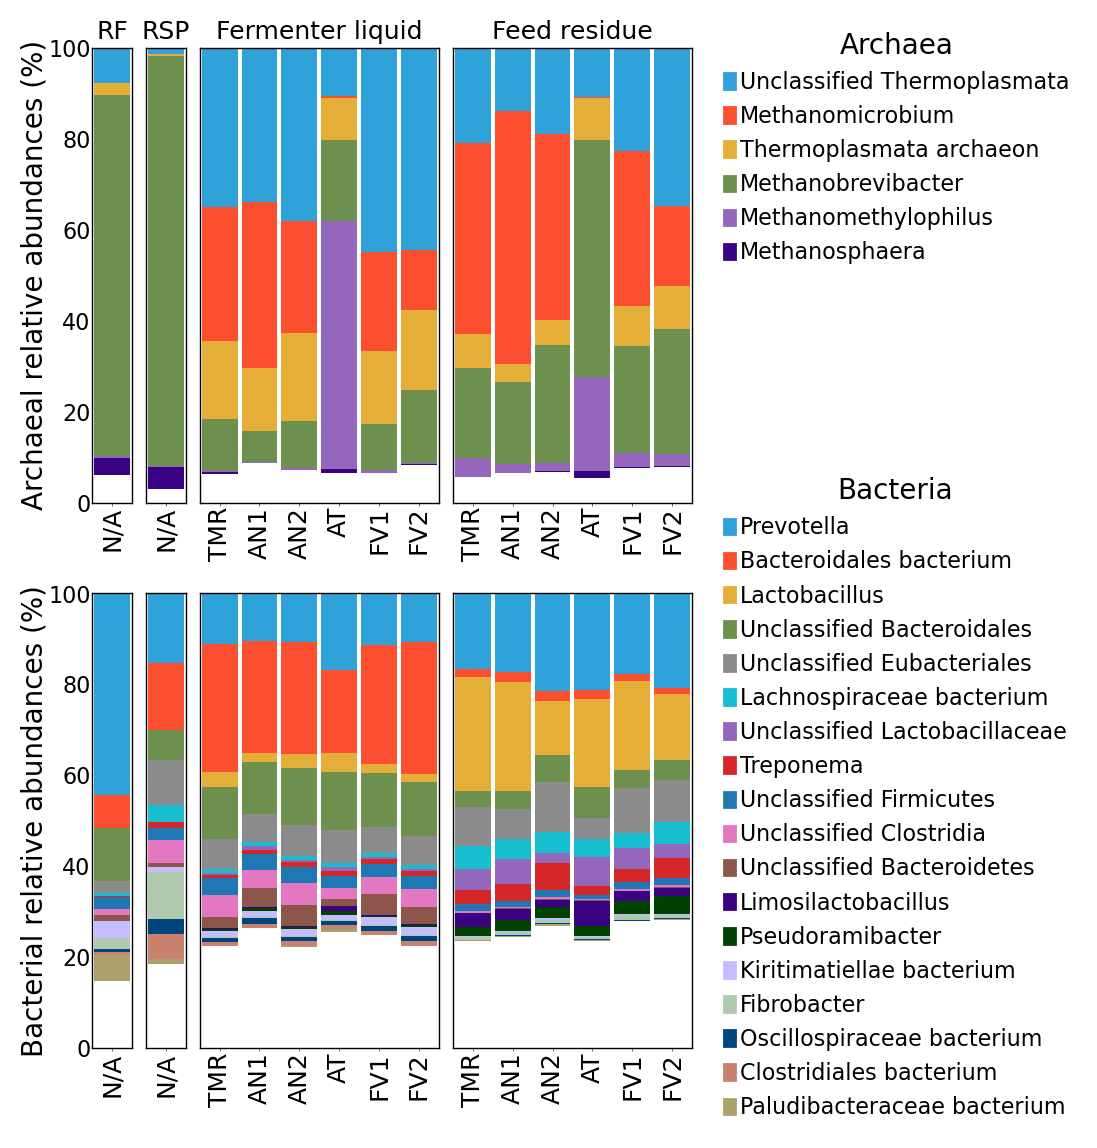

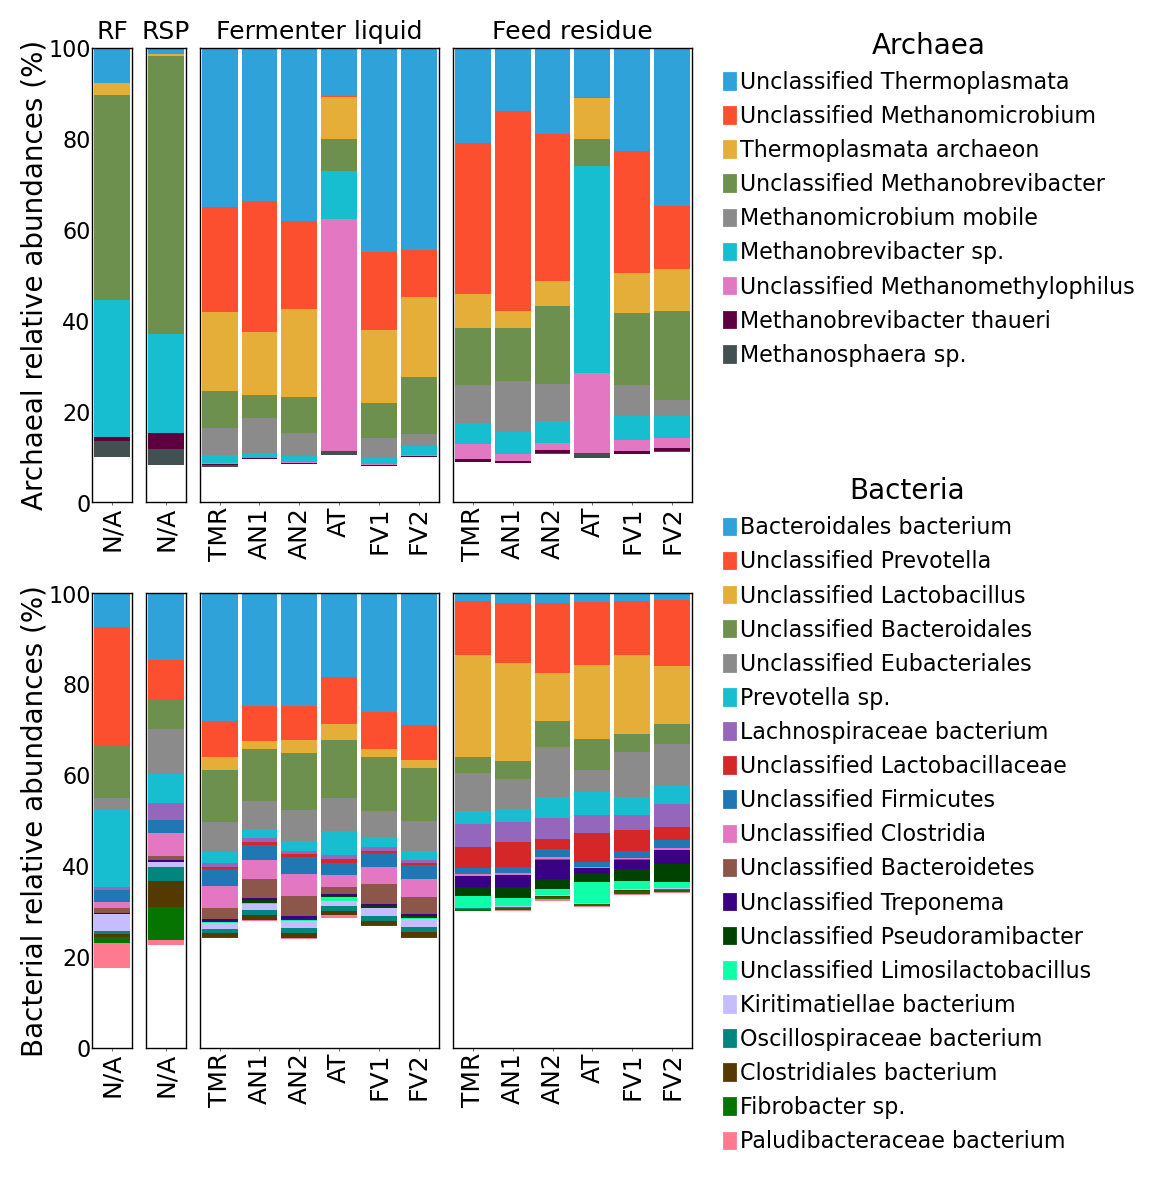

In [14]:
#Genera and species (Bacteria, Archaea)
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)
ratios = [len(meta.loc[meta.BS==g].Treatment.unique()) for g in meta.BS.unique()] #get wildth ratios

for lev in levels:
    fig,axes = plt.subplots(2,4,figsize=(3,5),sharey='row',gridspec_kw={'wspace':.1,'hspace':.2,'width_ratios':ratios})
    axs,i = [[r,c] for r in range(2) for c in range(4)],0
    for j,dom in enumerate(domains):
        legend = []
        df = taxamod(bar_unzip('Results/Taxabarplots/%s-barplot.qzv'%dom,levels[lev]),levels[lev])
        df = df.groupby(level=0,axis=1).sum() #sum duplicates
        df.loc['mean'] = df.mean() #add a row with mean 
        df.sort_values(inplace=True,axis=1,by='mean',ascending=True)#sort features by sum of abundances
        df.drop(inplace=True,index='mean')
        df = df.div(df.sum(axis=1),axis=0)*100 #convert to % (rel ab)
        meta = meta.loc[df.index.tolist(),:] #remove filtered samples from metadata 
        meta = meta.sort_values(['Day_num','BS','Treatment'],ascending=[True,True,True]) #sort df

        cdict = dict(zip(df.columns.tolist()[::-1], colours)) #create a colorbar for legend
        data = pd.DataFrame() #store mean rel ab by sample-type, day and treatment
        for g in meta.BS_Trt.unique():
            tempmet = meta.loc[meta.BS_Trt==g].copy()
            tempdf = df.copy().drop([i for i in df.index if i not in tempmet.index])
            for col in tempdf.columns:
                data.loc[g,col]=tempdf[col].mean()
        for col in data.columns: # remove low abundant features 
            if data[col].max() < 3: 
                data = data.drop(col,axis=1)
        for group in meta.BS.unique(): #iterate through sample-types by days
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            submet = meta.loc[meta.BS==group].copy()
            subdata = data.loc[[j for j in data.index if j in submet.BS_Trt.tolist()],:] #data to plot
            subdata.index = subdata.index.str.replace('_d0_N/A','').str.split('_').str[-1]
            if 'TMR' in subdata.index:
                subdata = subdata.reindex(['TMR','AN1','AN2','AT','FV1','FV2'])
            bottom = [100-subdata.loc[j,:].sum() for j in subdata.index]
            for col in subdata.columns: # iterate through all features
                c = cdict[col]
                if col not in legend: legend = [col]+legend
                ax.bar(x=subdata.index,height=subdata[col],bottom=bottom,color=c,label=col,width=0.9,linewidth=.0)
                bottom = [a+b for a,b in zip(bottom, subdata[col].tolist())]    
            ax.tick_params(axis='both',labelsize=8,pad=0.5,length=0,width=0.2) # adjust ticks
            ax.tick_params(axis='x',labelrotation=90,length=1,labelsize=9) # adjust ticks
            ax.set_ylim(0,100) # set limit for y axis
            ax.set_xlim(-0.5,len(subdata.index)-0.5)
            #order = subdata.index
            #ax.set_xticklabels([x.split('_')[0] if 'N/A' in x else x.split('_')[-1] for x in subdata.index])
            ax.set_ylabel(dom+'l relative abundances (%)',fontsize=10,labelpad=0.1)
            if group != meta.BS.unique()[0]: ax.set_ylabel('')
            #else: ax.text(-3,1,'AB'[j],ha='center',fontsize=12,transform=ax.transAxes)
            if dom == 'Archaea':
                ax.text(0.5,1.02,stypes[group.split('_')[0]],ha='center',fontsize=9,transform=ax.transAxes)
            if group == meta.BS.unique()[-1]:
                labels = [f for f in data.columns[::-1] if f in legend]
                if dom == 'bac': labels += ['others']                     
                handles = [mpatches.Patch(fill=False,edgecolor='none',visible=False) if l == 'others' \
                                     else mpatches.Patch(color=cdict[l],label=l) for l in labels]
                ypos = 1.08
                if lev == 'genera'    and dom == 'Bacteria': ypos = 1.2
                if dom == 'Bacteria': ypos = 1.3
                leg = ax.legend(handles,labels,loc=2,bbox_to_anchor=(1.05,ypos),fontsize=8,frameon=False,
                                                handletextpad=0.2,handlelength=0.5,bbox_transform=ax.transAxes,title=dom,)    
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.savefig('Figures/Taxabarplots/Taxabarplot_%s.png'%lev,bbox_inches='tight',facecolor="w")

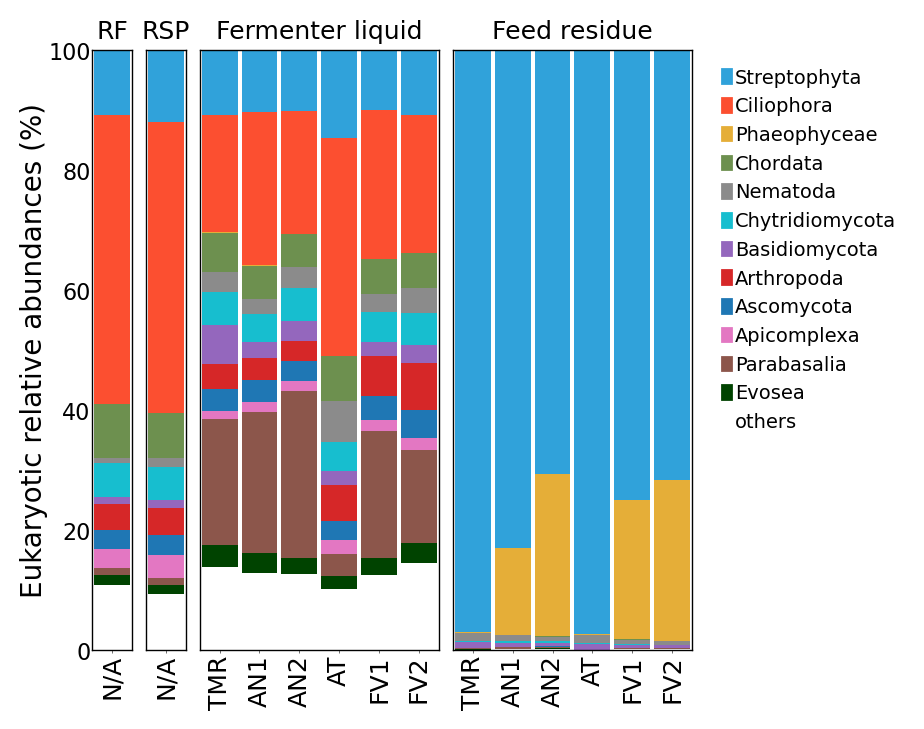

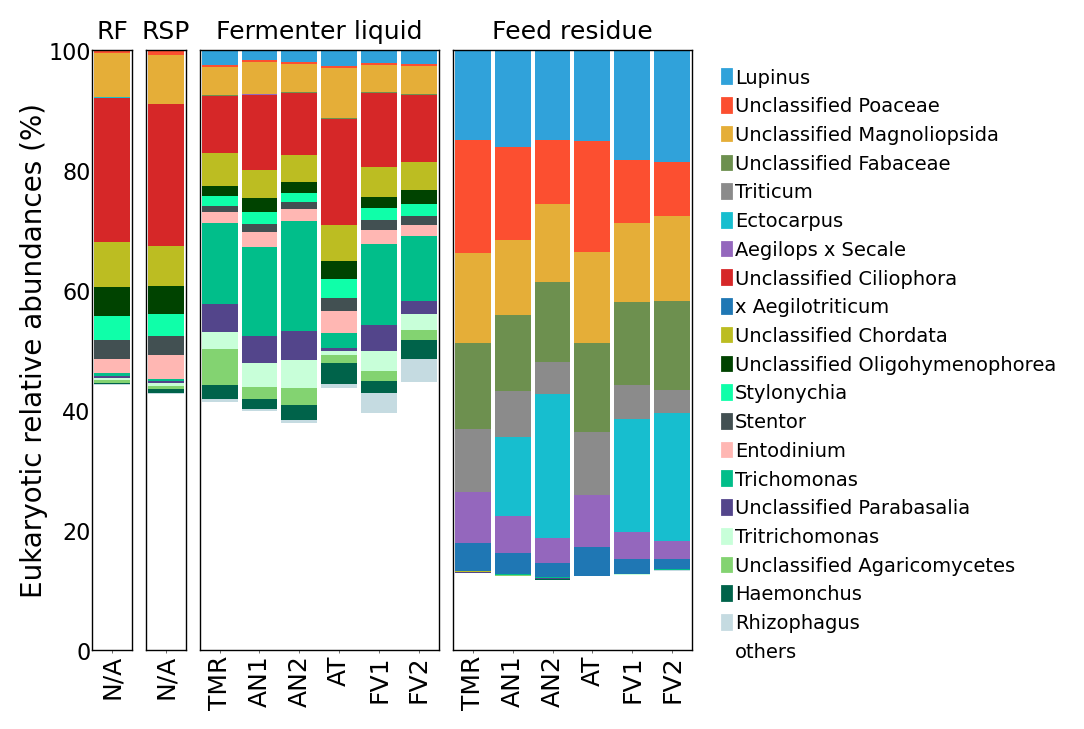

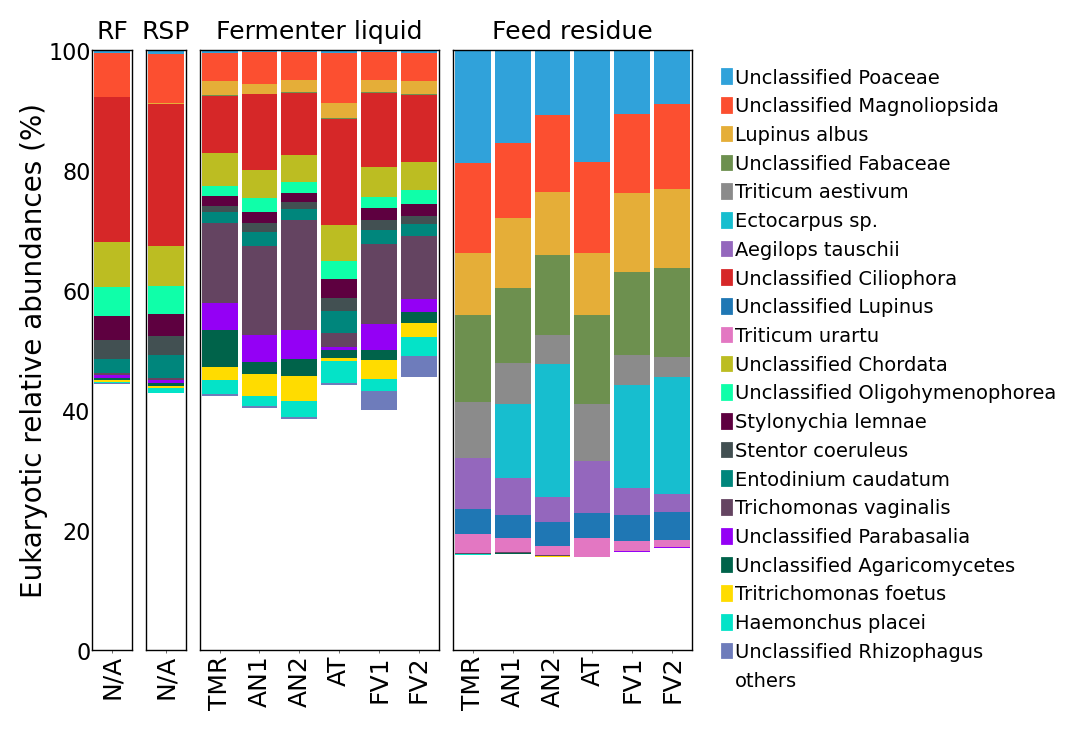

In [18]:
#Phyla, Genera and species (Eukaryota)
domains = ['Eukaryota']
levels = {'phyla':2,'genera':6,'species':7}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)
ratios = [len(meta.loc[meta.BS==g].Treatment.unique()) for g in meta.BS.unique()] #get wildth ratios

for lev in levels:
    fig,axes = plt.subplots(1,4,figsize=(3,3),sharey='row',gridspec_kw={'wspace':.1,'hspace':.2,'width_ratios':ratios})
    i = 0
    for j,dom in enumerate(domains):
        legend = []
        df = taxamod(bar_unzip('Results/Taxabarplots/%s-barplot.qzv'%dom,levels[lev]),levels[lev])
        df = df.groupby(level=0,axis=1).sum() #sum duplicates
        df.loc['mean'] = df.mean() #add a row with mean 
        df.sort_values(inplace=True,axis=1,by='mean',ascending=True)#sort features by sum of abundances
        df.drop(inplace=True,index='mean')
        df = df.div(df.sum(axis=1),axis=0)*100 #convert to % (rel ab)
        meta = meta.loc[df.index.tolist(),:] #remove filtered samples from metadata 
        meta = meta.sort_values(['Day_num','BS','Treatment'],ascending=[True,True,True]) #sort df

        cdict = dict(zip(df.columns.tolist()[::-1], colours)) #create a colorbar for legend
        data = pd.DataFrame() #store mean rel ab by sample-type, day and treatment
        for g in meta.BS_Trt.unique():
            tempmet = meta.loc[meta.BS_Trt==g].copy()
            tempdf = df.copy().drop([i for i in df.index if i not in tempmet.index])
            for col in tempdf.columns:
                data.loc[g,col]=tempdf[col].mean()
        for col in data.columns: # remove low abundant features 
            if data[col].max() < 3: 
                data = data.drop(col,axis=1)
        for group in meta.BS.unique(): #iterate through sample-types by days
            ax, i = axes[i], i+1
            submet = meta.loc[meta.BS==group].copy()
            subdata = data.loc[[j for j in data.index if j in submet.BS_Trt.tolist()],:] #data to plot
            subdata.index = subdata.index.str.replace('_d0_N/A','').str.split('_').str[-1]
            if 'TMR' in subdata.index:
                subdata = subdata.reindex(['TMR','AN1','AN2','AT','FV1','FV2'])
            bottom = [100-subdata.loc[j,:].sum() for j in subdata.index]
            for col in subdata.columns: # iterate through all features
                c = cdict[col]
                if col not in legend: legend = [col]+legend
                ax.bar(x=subdata.index,height=subdata[col],bottom=bottom,color=c,label=col,width=0.9,linewidth=.0)
                bottom = [a+b for a,b in zip(bottom, subdata[col].tolist())]    
            ax.tick_params(axis='both',labelsize=8,pad=0.5,length=0,width=0.2) # adjust ticks
            ax.tick_params(axis='x',labelrotation=90,length=1,labelsize=9) # adjust ticks
            ax.set_ylim(0,100) # set limit for y axis
            ax.set_xlim(-0.5,len(subdata.index)-0.5)
            #order = subdata.index
            #ax.set_xticklabels([x.split('_')[0] if 'N/A' in x else x.split('_')[-1] for x in subdata.index])
            ax.set_ylabel(dom[:-1]+'ic relative abundances (%)',fontsize=10,labelpad=0.1)
            if group != meta.BS.unique()[0]: ax.set_ylabel('')
            #else: ax.text(-3,1,'AB'[j],ha='center',fontsize=12,transform=ax.transAxes)
            ax.text(0.5,1.02,stypes[group.split('_')[0]],ha='center',fontsize=9,transform=ax.transAxes)
            if group == meta.BS.unique()[-1]:
                labels = [f for f in data.columns[::-1] if f in legend]
                labels += ['others']                     
                handles = [mpatches.Patch(fill=False,edgecolor='none',visible=False) if l == 'others' \
                                     else mpatches.Patch(color=cdict[l],label=l) for l in labels]
                ypos = 1
                #if lev == 'genera'    and dom == 'Bacteria': ypos = 1.2
                #if dom == 'Bacteria': ypos = 1.3
                leg = ax.legend(handles,labels,loc=2,bbox_to_anchor=(1.05,ypos),fontsize=7,frameon=False,
                                                handletextpad=0.2,handlelength=0.5,bbox_transform=ax.transAxes)    
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.savefig('Figures/Taxabarplots/Eukaryota_Taxabarplot_%s.png'%lev,bbox_inches='tight',facecolor="w")

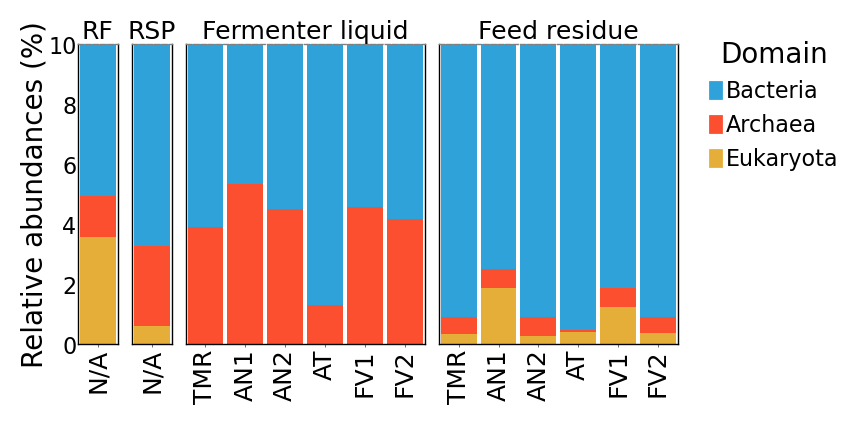

In [19]:
#Domains
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)
ratios = [len(meta.loc[meta.BS==g].Treatment.unique()) for g in meta.BS.unique()] #get wildth ratios

fig,axes = plt.subplots(1,4,figsize=(3,1.5),sharey='row',gridspec_kw={'wspace':.1,'hspace':.2,'width_ratios':ratios})

legend = []
df = taxamod(bar_unzip('Results/Taxabarplots/All-barplot.qzv',1),1)
df = df.groupby(level=0,axis=1).sum() #sum duplicates
df.loc['mean'] = df.mean() #add a row with mean 
df.sort_values(inplace=True,axis=1,by='mean',ascending=True)#sort features by sum of abundances
df.drop(inplace=True,index='mean')
df = df.div(df.sum(axis=1),axis=0)*100 #convert to % (rel ab)
meta = meta.loc[df.index.tolist(),:] #remove filtered samples from metadata 
meta = meta.sort_values(['Day_num','BS','Treatment'],ascending=[True,True,True]) #sort df

cdict = dict(zip(df.columns.tolist()[::-1], colours)) #create a colorbar for legend
data = pd.DataFrame() #store mean rel ab by sample-type, day and treatment
for g in meta.BS_Trt.unique():
    tempmet = meta.loc[meta.BS_Trt==g].copy()
    tempdf = df.copy().drop([i for i in df.index if i not in tempmet.index])
    for col in tempdf.columns:
        data.loc[g,col]=tempdf[col].mean()
for col in data.columns: # remove low abundant features 
    if data[col].max() < 3: 
        data = data.drop(col,axis=1)
for i,group in enumerate(meta.BS.unique()): #iterate through sample-types by days
    ax = axes[i]
    submet = meta.loc[meta.BS==group].copy()
    subdata = data.loc[[j for j in data.index if j in submet.BS_Trt.tolist()],:] #data to plot
    subdata.index = subdata.index.str.replace('_d0_N/A','').str.split('_').str[-1]
    if 'TMR' in subdata.index:
        subdata = subdata.reindex(['TMR','AN1','AN2','AT','FV1','FV2'])
    bottom = [100-subdata.loc[j,:].sum() for j in subdata.index]
    for col in subdata.columns: # iterate through all features
        c = cdict[col]
        if col not in legend: legend = [col]+legend
        ax.bar(x=subdata.index,height=subdata[col],bottom=bottom,color=c,label=col,width=0.9,linewidth=.0)
        bottom = [a+b for a,b in zip(bottom, subdata[col].tolist())]    
    ax.tick_params(axis='both',labelsize=8,pad=0.5,length=0,width=0.2) # adjust ticks
    ax.tick_params(axis='x',labelrotation=90,length=1,labelsize=9) # adjust ticks
    ax.set_ylim(0,10) # set limit for y axis
    ax.set_xlim(-0.5,len(subdata.index)-0.5)
 #order = subdata.index
 #ax.set_xticklabels([x.split('_')[0] if 'N/A' in x else x.split('_')[-1] for x in subdata.index])
    ax.set_ylabel('Relative abundances (%)',fontsize=10,labelpad=0.1)
    if group != meta.BS.unique()[0]: ax.set_ylabel('')
 #else: ax.text(-3,1,'AB'[j],ha='center',fontsize=12,transform=ax.transAxes)
    ax.text(0.5,1.02,stypes[group.split('_')[0]],ha='center',fontsize=9,transform=ax.transAxes)
    plt.setp(list(ax.spines.values())[3], color='grey',ls='--') # set color and style for upper line
    if group == meta.BS.unique()[-1]:
        labels = [f for f in data.columns[::-1] if f in legend]
 #if dom == 'bac': labels += ['others']                     
        handles = [mpatches.Patch(fill=False,edgecolor='none',visible=False) if l == 'others' \
                             else mpatches.Patch(color=cdict[l],label=l) for l in labels]
        ypos = 1.08
        leg = ax.legend(handles,labels,loc=2,bbox_to_anchor=(1.05,ypos),fontsize=8,frameon=False,
                                        handletextpad=0.2,handlelength=0.5,bbox_transform=ax.transAxes,title='Domain',)    
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('Figures/Taxabarplots/Taxabarplot_All_domains.png',bbox_inches='tight',facecolor="w")

## Statistical analysis of top features in barplots

In [18]:
#between sample-types
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Kruskal-Wallis general test + Kruskal-Wallis pairwise test for independent samples
def kw_test(df,col,metric,pairs,pairwise):
    phoc = pd.DataFrame(columns=['Group1','Group2','Mean1','Mean2','Stats','p'])
    kw = stats.kruskal(*[g[metric].values for n,g in df.groupby(col)])
    if kw[1] <= 0.05 and pairwise==True:
        if pairs == False: pairs = combinations(df[col].unique(),2)
        for pair in pairs:
            one,two = df.loc[df[col]==pair[0],metric].tolist(), df.loc[df[col]==pair[1],metric].tolist()
            r,p = stats.kruskal(one,two)
            phoc.loc[len(phoc)]=[pair[0],pair[1],np.average(one),np.average(two),r,p]
        phoc['q'] = multipletests(phoc.p,method='fdr_bh')[1]
    return kw,phoc

domains = {'Archaea':5,'Bacteria':10}

for dom in domains:
    meta = pd.read_csv(dom+'-metadata.tsv',sep='\t',index_col=0)
    df = taxamod(bar_unzip('Results/Taxabarplots/%s-taxabarplot.qzv'%dom,6),6)
    df = df.groupby(lambda x:x, axis=1).sum()
    df = df.append(df.agg(['sum'])) # add a row with sum 
    df.sort_values(inplace=True,axis=1,by='sum',ascending=False) # sort features by sum of abundances
    df.drop(inplace=True,index='sum')
    df = df.div(df.sum(axis=1),axis=0)*100
    df = df.iloc[:,:domains[dom]]
    meta = meta.loc[df.index.tolist(),:]
    meta = meta.sort_values(['BS','Treatment'],ascending=[True,True])
    data = pd.concat([meta, df], axis=1)
    display(data)
    
 # Between sample-types
    i = 0
    summary = pd.DataFrame()
    for feat in df.columns:
        kw,phoc = kw_test(data.copy(),'BS',feat,False,pairwise=True)
        if kw[1] <= 0.05:
            for ind in phoc.index:
                summary.loc[i,'Feature'] = feat
                summary.loc[i,'KW'] = kw[1]
                summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                summary.loc[i,'p'] = phoc.loc[ind,'p']
                summary.loc[i,'q'] = phoc.loc[ind,'q']
                i += 1
        else:
            summary.loc[i,'Feature'] = feat
            summary.loc[i,'KW'] = kw[1]
            summary.loc[i,'Group1'] = '-'
            summary.loc[i,'Group2'] = '-'
            summary.loc[i,'p'] = '-'
            summary.loc[i,'q'] = '-'
            i += 1
    summary.to_csv('Results/Taxabarplots/Between_BS_%s.tsv'%dom,sep='\t')
    
 # Between treatments by sample-types
    i = 0
    summary = pd.DataFrame()
    for bs in 'E','FL','FR':
        bsdata = data.loc[data.BS==bs].copy()
        for feat in df.columns:
            kw,phoc = kw_test(bsdata.copy(),'Treatment',feat,False,pairwise=True)
            if kw[1] <= 0.05:
                for ind in phoc.index:
                    summary.loc[i,'BS'] = bs
                    summary.loc[i,'Feature'] = feat
                    summary.loc[i,'KW'] = kw[1]
                    summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                    summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                    summary.loc[i,'p'] = phoc.loc[ind,'p']
                    summary.loc[i,'q'] = phoc.loc[ind,'q']
                    i += 1
            else:
                summary.loc[i,'BS'] = bs
                summary.loc[i,'Feature'] = feat
                summary.loc[i,'KW'] = kw[1]
                summary.loc[i,'Group1'] = '-'
                summary.loc[i,'Group2'] = '-'
                summary.loc[i,'p'] = '-'
                summary.loc[i,'q'] = '-'
                i += 1
    summary.to_csv('Results/Taxabarplots/Between_Treatments_%s.tsv'%dom,sep='\t')

,BS,Day,Day_hour,Treatment,Source,rstc_run,Day_num,BS_Dh,BS_Trt,IndID,Fermenter,shannon,faith_pd,evenness,observed_features,Methanobrevibacter,Methanomethylophilaceae,Methanomicrobium,Methanomethylophilus,Methanimicrococcus
149a,E,d13,NaN,AN1,HP1,rstc_run2,13,E_N/A,E_AN1,rrun2AN1HP1Ee,e,2.874889,1.507804,0.551860,37.0,7.037982,30.256718,43.672121,1.945654,16.324876
150a,E,d13,NaN,AN1,HP2,rstc_run2,13,E_N/A,E_AN1,rrun2AN1HP2Eg,g,3.478700,1.462844,0.658171,39.0,19.240506,37.971396,32.299852,2.847279,5.543317
70a,E,d13,NaN,AN1,HP1,rstc_run1,13,E_N/A,E_AN1,rrun1AN1HP1Ec,c,3.285182,1.511401,0.609234,42.0,22.497821,62.159077,11.862261,0.807422,1.747686
71a,E,d13,NaN,AN1,HP2,rstc_run1,13,E_N/A,E_AN1,rrun1AN1HP2El,l,3.498528,1.521893,0.653009,41.0,31.558140,45.388372,17.076744,3.302326,2.165116
151a,E,d13,NaN,AN2,HP1,rstc_run2,13,E_N/A,E_AN2,rrun2AN2HP1Ef,f,3.582279,1.379756,0.730051,30.0,18.219762,52.191271,23.727429,3.475184,1.088830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80a,RSP,d0,NaN,NaN,C1,rstc_run2,0,RSP_N/A,RSP_N/A,rrun2N/AC1RSPN/A,NaN,3.556118,1.558014,0.607055,58.0,87.015598,5.920277,0.350087,0.580589,0.032929
81a,RSP,d0,NaN,NaN,C2,rstc_run2,0,RSP_N/A,RSP_N/A,rrun2N/AC2RSPN/A,NaN,3.963134,1.552502,0.695233,52.0,73.675844,17.209999,0.430826,1.209538,0.048382
82a,RSP,d0,NaN,NaN,C3,rstc_run2,0,RSP_N/A,RSP_N/A,rrun2N/AC3RSPN/A,NaN,3.033250,1.714099,0.558994,43.0,85.037553,8.936541,0.006531,0.877327,0.000000
mix1-3a,RSP,d0,NaN,NaN,mix,rstc_run1,0,RSP_N/A,RSP_N/A,rrun1N/AmixRSPN/A,NaN,3.459518,1.266746,0.669162,36.0,78.280104,11.286146,0.205006,0.345274,0.000000


,BS,Day,Day_hour,Treatment,Source,rstc_run,Day_num,BS_Dh,BS_Trt,IndID,...,Lactobacillus,Prevotella,Bacteroidales (F082),Limosilactobacillus,Rikenellaceae (RC9 gut),Prevotellaceae,Treponema,Prevotellaceae (YAB2003),Pseudoramibacter,Streptococcus
149b,E,d13,NaN,AN1,HP1,rstc_run2,13,E_N/A,E_AN1,rrun2AN1HP1Ee,...,9.269154,8.915916,18.301326,3.056183,7.460484,1.307876,2.266986,0.909924,2.025532,2.984641
150b,E,d13,NaN,AN1,HP2,rstc_run2,13,E_N/A,E_AN1,rrun2AN1HP2Eg,...,7.698238,8.054239,16.532505,6.421623,8.172150,2.099726,2.092923,0.804970,2.258452,3.507857
70b,E,d13,NaN,AN1,HP1,rstc_run1,13,E_N/A,E_AN1,rrun1AN1HP1Ec,...,4.832592,10.900015,8.960738,3.523867,5.047702,0.924482,2.541914,0.702803,1.192138,3.425344
71b,E,d13,NaN,AN1,HP2,rstc_run1,13,E_N/A,E_AN1,rrun1AN1HP2El,...,7.112785,10.479206,14.470306,5.536539,7.528667,1.047407,2.750300,0.771864,0.682868,1.908266
151b,E,d13,NaN,AN2,HP1,rstc_run2,13,E_N/A,E_AN2,rrun2AN2HP1Ef,...,2.197734,3.930503,31.599014,1.723470,6.991522,0.292928,0.919081,0.049596,0.125541,0.371972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3b,RSP,d0,NaN,NaN,C3,rstc_run1,0,RSP_N/A,RSP_N/A,rrun1N/AC3RSPN/A,...,0.010724,16.713734,4.178880,0.000000,4.786588,0.834704,5.724959,0.119754,0.000000,0.023236
80b,RSP,d0,NaN,NaN,C1,rstc_run2,0,RSP_N/A,RSP_N/A,rrun2N/AC1RSPN/A,...,0.000000,12.293697,4.505709,0.000000,6.802191,0.289613,6.869024,0.000000,0.000000,0.000000
81b,RSP,d0,NaN,NaN,C2,rstc_run2,0,RSP_N/A,RSP_N/A,rrun2N/AC2RSPN/A,...,0.000000,10.332941,5.423711,0.000000,7.315341,0.434798,6.631098,0.000000,0.000000,0.000000
mix1-3b,RSP,d0,NaN,NaN,mix,rstc_run1,0,RSP_N/A,RSP_N/A,rrun1N/AmixRSPN/A,...,0.036399,13.791962,5.474761,0.018200,5.842061,0.418590,4.884102,0.097616,0.000000,0.023163


In [ ]:
#between treatments
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Kruskal-Wallis general test + Kruskal-Wallis pairwise test for independent samples
def kw_test(df,col,metric,pairs,pairwise):
    phoc = pd.DataFrame(columns=['Group1','Group2','Mean1','Mean2','Stats','p'])
    kw = stats.kruskal(*[g[metric].values for n,g in df.groupby(col)])
    if kw[1] <= 0.05 and pairwise==True:
        if pairs == False: pairs = combinations(df[col].unique(),2)
        for pair in pairs:
            one,two = df.loc[df[col]==pair[0],metric].tolist(), df.loc[df[col]==pair[1],metric].tolist()
            r,p = stats.kruskal(one,two)
            phoc.loc[len(phoc)]=[pair[0],pair[1],np.average(one),np.average(two),r,p]
        phoc['q'] = multipletests(phoc.p,method='fdr_bh')[1]
    return kw,phoc

domains = {'Archaea':5,'Bacteria':10}

for dom in domains:
    meta = pd.read_csv(dom+'-metadata.tsv',sep='\t',index_col=0)
    df = taxamod(bar_unzip('Results/Taxabarplots/%s-taxabarplot.qzv'%dom,6),6)
    df = df.groupby(lambda x:x, axis=1).sum()
    df = df.append(df.agg(['sum'])) # add a row with sum 
    df.sort_values(inplace=True,axis=1,by='sum',ascending=False) # sort features by sum of abundances
    df.drop(inplace=True,index='sum')
    df = df.div(df.sum(axis=1),axis=0)*100
    df = df.iloc[:,:domains[dom]]
    meta = meta.loc[df.index.tolist(),:]
    meta = meta.sort_values(['BS','Treatment'],ascending=[True,True])
    data = pd.concat([meta, df], axis=1)
 #display(data)
    
 # Between sample-types and days of sampling
    i = 0
    summary = pd.DataFrame()
    for feat in df.columns:
        kw,phoc = kw_test(data.copy(),'BS',feat,False,pairwise=True)
        if kw[1] <= 0.05:
            for ind in phoc.index:
                summary.loc[i,'Feature'] = feat
                summary.loc[i,'KW'] = kw[1]
                summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                summary.loc[i,'p'] = phoc.loc[ind,'p']
                summary.loc[i,'q'] = phoc.loc[ind,'q']
                i += 1
        else:
            summary.loc[i,'Feature'] = feat
            summary.loc[i,'KW'] = kw[1]
            summary.loc[i,'Group1'] = '-'
            summary.loc[i,'Group2'] = '-'
            summary.loc[i,'p'] = '-'
            summary.loc[i,'q'] = '-'
            i += 1
    summary.to_csv('Results/Taxabarplots/Between_BS_%s.tsv'%dom,sep='\t')

# Methanobrevibacter clades

In [21]:
# Archaeal species relative abundances 
table = f'{TABS}/Archaea-species-table.qza'
tabre = f'{TABS}/Archaea-species-rel_table.qza'

!qiime feature-table relative-frequency \
    --i-table $table \
    --o-relative-frequency-table $tabre

!qiime tools export \
    --input-path $tabre \
    --output-path Data/Tables
!biom convert -i Data/Tables/feature-table.biom -o Data/Tables/Archaea-species-rel_table.tsv --to-tsv
!rm Data/Tables/feature-table.biom

# All domains relative abundances 
table = 'Data/Tables/species-table.qza'
tabdom = 'Data/Tables/All-domains_table.qza'
tabdomre = 'Data/Tables/All-domains_rel_table.qza'

!qiime taxa collapse \
    --i-table $table \
    --i-taxonomy Data/taxonomy.qza \
    --p-level 1 \
    --o-collapsed-table $tabdom

!qiime feature-table relative-frequency \
    --i-table $tabdom \
    --o-relative-frequency-table $tabdomre

!qiime tools export \
    --input-path $tabdomre \
    --output-path Data/Tables
!biom convert -i Data/Tables/feature-table.biom -o Data/Tables/All-domains_rel_table.tsv --to-tsv
!rm Data/Tables/feature-table.biom

!mkdir Figures/Clades Results/Clades

Saved FeatureTable[RelativeFrequency] to: Data/Tables/Archaea-species-rel_table.qza
Exported Data/Tables/Archaea-species-rel_table.qza as BIOMV210DirFmt to directory Data/Tables
Saved FeatureTable[Frequency] to: Data/Tables/All-domains_table.qza
Saved FeatureTable[RelativeFrequency] to: Data/Tables/All-domains_rel_table.qza
Exported Data/Tables/All-domains_rel_table.qza as BIOMV210DirFmt to directory Data/Tables
mkdir: cannot create directory ‘Figures/Clades’: File exists
mkdir: cannot create directory ‘Results/Clades’: File exists


,BS,Feature,KW,Group1,Group2,p,q
0,FL,AB_ratios,0.026675,TMR,AN1,0.083265,0.138774
1,FL,AB_ratios,0.026675,TMR,AN2,0.043308,0.129924
2,FL,AB_ratios,0.026675,TMR,AT,0.248213,0.310266
3,FL,AB_ratios,0.026675,TMR,FV1,0.043308,0.129924
4,FL,AB_ratios,0.026675,TMR,FV2,0.148915,0.223372
5,FL,AB_ratios,0.026675,AN1,AN2,0.386476,0.414082
6,FL,AB_ratios,0.026675,AN1,AT,0.043308,0.129924
7,FL,AB_ratios,0.026675,AN1,FV1,0.386476,0.414082
8,FL,AB_ratios,0.026675,AN1,FV2,0.248213,0.310266
9,FL,AB_ratios,0.026675,AN2,AT,0.043308,0.129924


,BS,Feature,KW,Group1,Group2,p,q
0,FL,EB_ratios,0.33131,-,-,-,-


,BS,Feature,KW,Group1,Group2,p,q
0,FL,AE_ratios,0.07609,-,-,-,-


,BS,Feature,KW,Group1,Group2,p,q
0,FL,SGMT,0.011628,TMR,AN1,0.083265,0.156121
1,FL,SGMT,0.011628,TMR,AN2,0.386476,0.445934
2,FL,SGMT,0.011628,TMR,AT,0.020921,0.062764
3,FL,SGMT,0.011628,TMR,FV1,0.77283,0.828032
4,FL,SGMT,0.011628,TMR,FV2,1.0,1.0
5,FL,SGMT,0.011628,AN1,AN2,0.148915,0.203065
6,FL,SGMT,0.011628,AN1,AT,0.020921,0.062764
7,FL,SGMT,0.011628,AN1,FV1,0.148915,0.203065
8,FL,SGMT,0.011628,AN1,FV2,0.043308,0.10827
9,FL,SGMT,0.011628,AN2,AT,0.020921,0.062764


,BS,Feature,KW,Group1,Group2,p,q
0,FR,AB_ratios,0.042155,AT,FV1,0.020921,0.062764
1,FR,AB_ratios,0.042155,AT,FV2,0.020921,0.062764
2,FR,AB_ratios,0.042155,AT,TMR,0.020921,0.062764
3,FR,AB_ratios,0.042155,AT,AN1,0.020921,0.062764
4,FR,AB_ratios,0.042155,AT,AN2,0.020921,0.062764
5,FR,AB_ratios,0.042155,FV1,FV2,0.386476,0.579714
6,FR,AB_ratios,0.042155,FV1,TMR,0.248213,0.465400
7,FR,AB_ratios,0.042155,FV1,AN1,0.386476,0.579714
8,FR,AB_ratios,0.042155,FV1,AN2,1.000000,1.000000
9,FR,AB_ratios,0.042155,FV2,TMR,0.772830,0.828032


,BS,Feature,KW,Group1,Group2,p,q
0,FR,EB_ratios,0.72925,-,-,-,-


,BS,Feature,KW,Group1,Group2,p,q
0,FR,AE_ratios,0.145552,-,-,-,-


,BS,Feature,KW,Group1,Group2,p,q
0,FR,SGMT,0.062246,-,-,-,-
1,FR,RO,0.718480,-,-,-,-


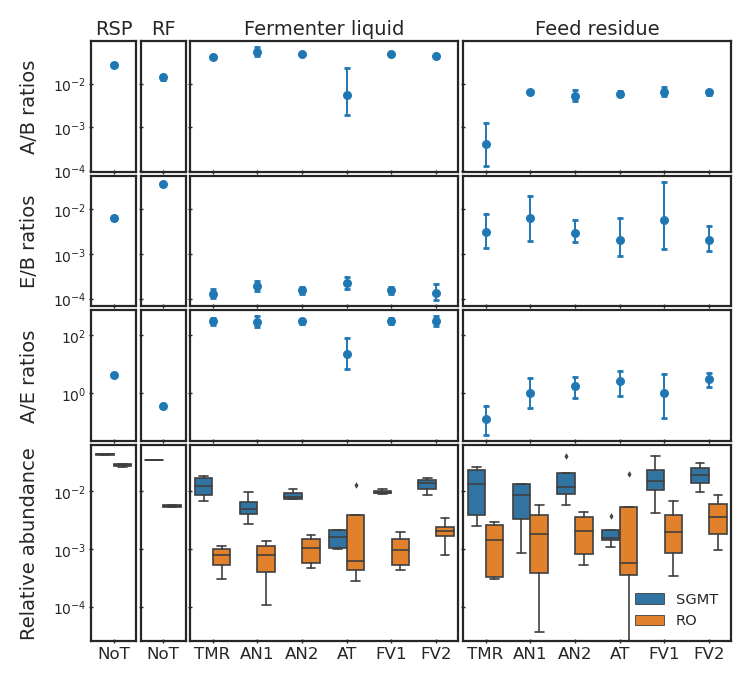

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import sys
sys.path.append('/home/timyerg/Dropbox/TY_scripts')
sys.path.append('/home/meco/Dropbox/TY_scripts')
%matplotlib inline 

plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure


# Kruskal-Wallis general test + Kruskal-Wallis pairwise test for independent samples
def kw_test(df,col,metric,pairs=False,pairwise=True):
    phoc = pd.DataFrame(columns=['Group1','Group2','Mean1','Mean2','Stats','p'])
    kw = stats.kruskal(*[g[metric].values for n,g in df.groupby(col)])
    if kw[1] <= 0.05 and pairwise==True:
        if pairs == False: pairs = combinations(df[col].unique(),2)
        for pair in pairs:
            one,two = df.loc[df[col]==pair[0],metric].tolist(), df.loc[df[col]==pair[1],metric].tolist()
            r,p = stats.kruskal(one,two)
            phoc.loc[len(phoc)]=[pair[0],pair[1],np.median(one),np.median(two),r,p]
        phoc['q'] = multipletests(phoc.p,method='fdr_bh')[1]
    return kw,phoc

#Summarize kw
def summarize(summary,j,kw,group,feat):
    if kw[1] <= 0.05:
        for ind in phoc.index:
            summary.loc[j,'BS'] = group
            summary.loc[j,'Feature'] = feat
            summary.loc[j,'KW'] = kw[1]
            summary.loc[j,'Group1'] = phoc.loc[ind,'Group1']
            summary.loc[j,'Group2'] = phoc.loc[ind,'Group2']
            summary.loc[j,'p'] = phoc.loc[ind,'p']
            summary.loc[j,'q'] = phoc.loc[ind,'q']
            j += 1
    else:
        summary.loc[j,'BS'] = group
        summary.loc[j,'Feature'] = feat
        summary.loc[j,'KW'] = kw[1]
        summary.loc[j,'Group1'] = '-'
        summary.loc[j,'Group2'] = '-'
        summary.loc[j,'p'] = '-'
        summary.loc[j,'q'] = '-'
        j += 1
    return summary,j
                

names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','NoT':'NoT'}
stypes = {'RSP':'RSP','RF':'RF','FL':'Fermenter liquid','FR':'Feed residue'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta['BS_Trt']  = meta['BS'] +'_'+ meta['Trt']
#meta = meta.replace(names,regex=True)

# Domains ratios
doms = pd.read_csv('Data/Tables/All-domains_rel_table.tsv',sep='\t',skiprows=1,index_col=0)
doms = doms.T
doms['AB_ratios'] = doms['k_Archaea']/doms['k_Bacteria']
doms['EB_ratios'] = doms['k_Eukaryota']/doms['k_Bacteria']
doms['AE_ratios'] = doms['k_Archaea']/doms['k_Eukaryota']
#doms['EA_ratios'] = doms['k_Eukaryota']/doms['k_Archaea']
doms['BS_Trt'] = meta['BS_Trt']
doms[['BS','Trt']] = doms.BS_Trt.str.split('_',expand=True)

# Mbb. clades
clades = {'SGMT':['smithii','gottschalkii','millerae','thaueri'],'RO':['ruminantium','olleyae']}
order = [v for v in names.values() if v!='NoT']
horder = list(clades.keys())

rel = pd.read_csv('Data/Tables/Archaea-species-rel_table.tsv',sep='\t',skiprows=1,index_col=0)
clade_data = pd.DataFrame()
for clade in clades:
    df = rel.loc[[i for i in rel.index if any(s in i for s in clades[clade])]]
    df['clade'] = clade
    clade_data = pd.concat([clade_data,df],axis=0)
clade_data = clade_data.groupby(['clade']).sum().T
clade_data['ratios'] = clade_data['SGMT']/clade_data['RO']
clade_data['BS_Trt'] = meta['BS_Trt'] 
clade_df = clade_data.melt(id_vars='BS_Trt',value_vars=['RO','SGMT']).copy()
clade_df[['BS','Trt']] = clade_df.BS_Trt.str.split('_',expand=True)
clade_data[['BS','Trt']] = clade_data.BS_Trt.str.split('_',expand=True)

# Declare figure
ratios = [len(clade_df.loc[clade_df.BS==g].Trt.unique()) for g in clade_df.BS.unique()] #get wildth ratios
fig,axes = plt.subplots(4, 4, figsize=(3.2, 3), sharex='col', sharey='row',
           gridspec_kw={'wspace': .03, 'hspace': .025, 'width_ratios': ratios, 'height_ratios': [1, 1, 1, 1.5]})
axs,i = [[r,c] for r in range(4) for c in range(4)],0

for ax in axes.reshape(-1):
    ax.tick_params(axis='both', labelsize=5, pad=1, length=1.6, width=.5, direction='inout')
    ax.tick_params(axis='x', labelsize=6)

for i, group in enumerate(stypes): #iterate through sample-types
    
 #domains ratios and stat analysis
    for j, col in enumerate(['AB_ratios', 'EB_ratios', 'AE_ratios']): 
        ax1 = axes[axs[i+len(ratios)*j][0]][axs[i+len(ratios)*j][1]]
        ax1.set(yscale="log")
        ax1.minorticks_off()
        df = doms.loc[doms.BS==group].copy()
        if group in ['FL','FR']:
            summary,ind = pd.DataFrame(),0
            for feat in [col]:
                kw,phoc = kw_test(df,'Trt',feat)
                summary,ind = summarize(summary,ind,kw,group,feat)

            summary.to_csv('Results/Clades/Doms-ratios_%s_%s_Treatments.tsv'%(group,col),sep='\t')
 #ax1.text(.99,.93,'P '+str(round(summary['KW'].min(),3)),size=5,transform=ax2.transAxes,ha='right')
            display(summary)
        order = [v for v in names.values() if v in df.Trt.unique()]
        #sns.boxplot(x='Trt',y=col,data=df,ax=ax1,linewidth=0.7,fliersize=0.3,color='whitesmoke',order=order)
        sns.lineplot(x='Trt', y=col, data=df, ax=ax1, marker='o', linestyle='', err_style='bars', 
                     markersize=4, err_kws={'elinewidth': 0.7, 'capsize': 1})
        ax1.set_ylabel(f'{col[0]}/{col[1]} {col.split("_")[-1]}',fontsize=7,labelpad=5)
        if j == 0:
            ax1.text(0.5,1.05,stypes[group],ha='center',fontsize=7,transform=ax1.transAxes)
        ax1.set_xlabel('')
        if group != 'RSP': 
            ax1.set_ylabel('')
    
 #rel. ab. of sgmt and ro clades and stat analysis
    j += 1
    ax2 = axes[axs[i+len(ratios)*j][0]][axs[i+len(ratios)*j][1]]
    ax2.set(yscale="log")
    ax2.minorticks_off()
    df = clade_df.loc[clade_df.BS==group].copy()
    
    if group in ['FL','FR']:
        summary,j = pd.DataFrame(),0
        for feat in 'SGMT','RO':
            bsdata = df.loc[(df.clade==feat)].copy()
            kw,phoc = kw_test(bsdata.copy(),'Trt','value')
            summary,j = summarize(summary,j,kw,group,feat)

        summary.to_csv('Results/Clades/Clades_%s_Treatments.tsv'%group,sep='\t')
 #ax1.text(.99,.93,'P '+str(round(summary['KW'].min(),3)),size=5,transform=ax1.transAxes,ha='right')
        display(summary)    
    order = [v for v in names.values() if v in df.Trt.unique()]
    horder = list(clades.keys())
    sns.boxplot(x='Trt',y='value',data=df,ax=ax2,linewidth=0.6,fliersize=0.3,hue='clade',order=order,hue_order=horder)
    #sns.lineplot(x='Trt', y='ratios', data=df, ax=ax2, marker='o', linestyle='', err_style='bars', 
    #                 markersize=4, err_kws={'elinewidth': 0.7, 'capsize': 1})
    ax2.set_ylabel('Relative abundance',fontsize=7,labelpad=5) 
    if group != 'FR': 
        ax2.get_legend().remove()
    else:                         
        ax2.legend(loc=4,frameon=False,fontsize=5.25)
    ax2.set_xlabel('')
    if group != 'RSP': 
        ax2.set_ylabel('')
        

fig.align_labels()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)    
plt.savefig('Figures/Clades/sgmt-ro_ratios.png',bbox_inches='tight',facecolor="w")

Checking normality of ratios


,Metric,Stats,p
0,AB_ratios,0.8255,0.000002
1,EB_ratios,0.478049,0.0
2,AE_ratios,0.753934,0.0


Checking normality of Mbb. clades ratios


,Metric,Stats,p
0,Mbb. clades ratios,0.911135,0.000895


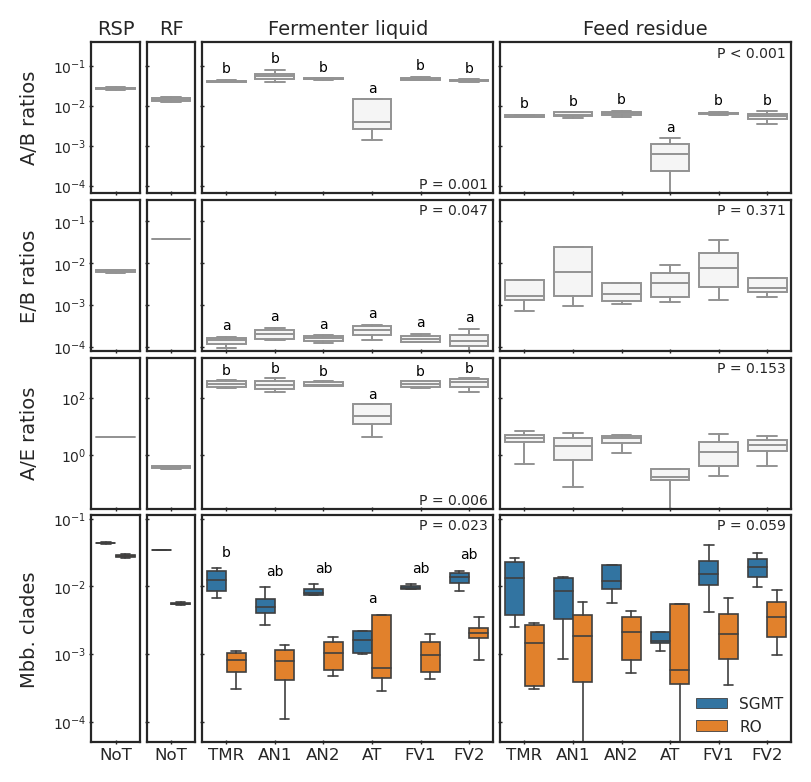

In [13]:
#with anova

META['BS_Trt_Run'] = META['BS'] +'_'+ META['Trt'] +'_'+ META['rstc_run']
# Domains ratios
out = 'Results/Clades'
rats = ['AB_ratios', 'EB_ratios', 'AE_ratios']
doms = pd.read_csv(f'{TABS}/All-domains_rel_table.tsv', 
                   sep='\t', skiprows=1, index_col=0)
doms = doms.T
doms['AB_ratios'] = doms['k_Archaea']/doms['k_Bacteria']
doms['EB_ratios'] = doms['k_Eukaryota']/doms['k_Bacteria']
doms['AE_ratios'] = doms['k_Archaea']/doms['k_Eukaryota']
#doms['EA_ratios'] = doms['k_Eukaryota']/doms['k_Archaea']
doms[['BS', 'Trt', 'Run']] = META[['BS', 'Trt', 'rstc_run']]
doms.replace([np.inf, -np.inf], 0, inplace=True)

#check domain ratios normality
norm = pd.DataFrame(columns=['Metric', 'Stats', 'p'])
for rat in rats:
    data = doms[doms[rat].notna()].copy()
    i = len(norm)
    norm.loc[i, 'Metric'] = rat
    norm.loc[i, ['Stats', 'p']] = stats.shapiro(data[rat])
norm.to_csv(f'{out}/rats_normality.tsv', sep='\t', index=False)
print('Checking normality of ratios')
display(norm)

# Mbb. clades
clades = {
    'SGMT': ['smithii', 'gottschalkii', 'millerae', 'thaueri'],
    'RO': ['ruminantium', 'olleyae']}

rel = pd.read_csv(f'{TABS}/Archaea-species-rel_table.tsv',
                  sep='\t', skiprows=1, index_col=0)
clade_data = pd.DataFrame()
for clade in clades:
    df = rel.loc[[i for i in rel.index if any(s in i for s in clades[clade])]]
    df['clade'] = clade
    clade_data = pd.concat([clade_data, df], axis=0)
clade_data = clade_data.groupby(['clade']).sum().T
clade_data['ratios'] = clade_data['SGMT']/clade_data['RO']
clade_data.replace([np.inf, -np.inf], 0, inplace=True)
clade_data['BS_Trt_Run'] = META['BS_Trt_Run']
clade_df = clade_data.melt(id_vars='BS_Trt_Run', value_vars=['RO', 'SGMT']).copy()
clade_df[['BS', 'Trt', 'Run']] = clade_df.BS_Trt_Run.str.split('_', n=2, expand=True)
clade_data[['BS', 'Trt', 'Run']] = clade_data.BS_Trt_Run.str.split('_', n=2, expand=True)

#check clades ratios normality
norm = pd.DataFrame(columns=['Metric', 'Stats', 'p'])
i = len(norm)
norm.loc[i, 'Metric'] = 'Mbb. clades ratios'
norm.loc[i, ['Stats', 'p']] = stats.shapiro(clade_data['ratios'])
norm.to_csv(f'{out}/Mbb_clades_ratios_normality.tsv', sep='\t', index=False)
print('Checking normality of Mbb. clades ratios')
display(norm)

#get y limits
yAB = [doms['AB_ratios'].min(), doms['AB_ratios'].max()]
yEB = [doms['EB_ratios'].min(), doms['EB_ratios'].max()]
yAE = [doms['AE_ratios'].min(), doms['AE_ratios'].max()]
yMb = [clade_df['value'].min(), clade_df['value'].max()]
ylims = [yAB, yEB, yAE, yMb]

# Declare figure

#get wildth ratios
ratios = [len(clade_df.loc[clade_df.BS==g].Trt.unique()) for g in clade_df.BS.unique()] 
fig, axes = plt.subplots(4, 4, figsize=(3.5, 3.5), sharex='col', sharey='row',
           gridspec_kw={'wspace': .04, 'hspace': .04, 'width_ratios': ratios, 
                        'height_ratios': [1, 1, 1, 1.5]})
axs, i = [[r, c] for r in range(4) for c in range(4)], 0
for ax in axes.reshape(-1):
    ax.tick_params(axis='both', labelsize=5, pad=1, length=1.6, width=.5, direction='inout')
    ax.tick_params(axis='x', labelsize=6)
    
for i, st in enumerate(STYPES): #iterate through sample-types
    
    #domains ratios
    for j, rat in enumerate(rats):
        
        #plot
        ax1 = axes[axs[i+len(ratios)*j][0]][axs[i+len(ratios)*j][1]]
        ax1.set(yscale="log")
        ax1.minorticks_off()
        ax1.set_ylim(ylims[j][0], ylims[j][1]*5)
        df = doms.loc[doms.BS == st].copy()
        order = [v for v in CDICT if v in df.Trt.unique()]
        sns.boxplot(x='Trt', y=rat, data=df, linewidth=0.7, showfliers=False, 
                    order=order, color='whitesmoke', showmeans=False, ax=ax1,)
                    #meanprops={"marker": ".", "markersize": 2.5, "markeredgecolor": "black"})
        ax1.set_ylabel(f'{rat[0]}/{rat[1]} {rat.split("_")[-1]}', fontsize=7, labelpad=5)
        if j == 0:
            ax1.text(.5, 1.05, STYPES[st], ha='center', fontsize=7, transform=ax1.transAxes)
        ax1.set_xlabel('')
        if st != 'RSP': 
            ax1.set_ylabel('')
        
        #stats
        if st in ['FL', 'FR']:
            formula= f'{rat} ~ Trt + Run'
            anova, pairwise, residuals = run_anova(formula, df)
            anova.to_csv(f'{out}/{st}_{rat}_anova_Trt.tsv', sep='\t')
            pairwise.to_csv(f'{out}/{st}_{rat}_anova_Trt_pairs.tsv', sep='\t')
            residuals.to_csv(f'{out}/{st}_{rat}_anova_Trt_residuals.tsv', sep='\t')
            pairwise = pairwise.loc[~pairwise.index.str.contains('rstc')].copy()
            pairwise['Pair'] = pairwise.index
            pairwise[['Group1', 'Group2']] = pairwise.Pair.str.split('-', expand=True)
            cld = ABCstat(pairwise,'Group1', 'Group2', 'pvalue-fdr_bh')
            p_gen = round(anova.loc['Trt', 'PR(>F)'], 3)
            p = f'P = {p_gen}'
            if p_gen == 0.0:
                p = f'P < 0.001'
            ytxt = .9
            if rat in ['AE_ratios', 'AB_ratios'] and st == 'FL':
                ytxt = .03
            ax1.text(.98, ytxt, p, size=5, transform=ax1.transAxes, ha='right')
            if p_gen <= .05:
                for ix, x in enumerate(order):
                    y = mpl.cbook.boxplot_stats(df.loc[df.Trt == x][rat])[0]['whishi']
                    let = cld.loc[x, 'letters']
                    ax1.text(ix, y * 1.5, let, size=5, ha='center', color='black')

    #rel. ab. of sgmt and ro clades
    
    #plot
    j += 1
    ax2 = axes[axs[i+len(ratios)*j][0]][axs[i+len(ratios)*j][1]]
    ax2.set(yscale="log")
    ax2.minorticks_off()
    ax2.set_ylim(.00005, ylims[j][1]*2.5)
    df = clade_df.loc[clade_df.BS==st].copy()   
    order = [v for v in CDICT if v in df.Trt.unique()]
    sns.boxplot(x='Trt', y='value', data=df, ax=ax2, linewidth=0.6, showfliers=False,
                hue='clade', order=order, hue_order=clades, showmeans=False,)
                #meanprops={"marker": ".", "markersize": 2.5, "markeredgecolor": "black"})
    ax2.set_ylabel('Mbb. clades', fontsize=7, labelpad=5) 
    if st != 'FR': 
        ax2.get_legend().remove()
    else:                         
        ax2.legend(loc=4, frameon=False, fontsize=5.5, borderpad=.02)
    ax2.set_xlabel('')
    if st != 'RSP': 
        ax2.set_ylabel('')
    
    #stats
    if st in ['FL', 'FR']:
        bsdata = clade_data.loc[clade_data.BS==st].copy()  
        formula= f'ratios ~ Trt + Run'
        anova, pairwise, residuals = run_anova(formula, bsdata)
        anova.to_csv(f'{out}/{st}_Mbb_clades_ratios_anova_Trt.tsv', sep='\t')
        pairwise.to_csv(f'{out}/{st}_Mbb_clades_ratios_anova_Trt_pairs.tsv', sep='\t')
        residuals.to_csv(f'{out}/{st}_Mbb_clades_ratios_anova_Trt_residuals.tsv', sep='\t')
        pairwise = pairwise.loc[~pairwise.index.str.contains('rstc')].copy()
        pairwise['Pair'] = pairwise.index
        pairwise[['Group1', 'Group2']] = pairwise.Pair.str.split('-', expand=True)
        cld = ABCstat(pairwise,'Group1', 'Group2', 'pvalue-fdr_bh')
        p_gen = round(anova.loc['Trt', 'PR(>F)'], 3)
        p = f'P = {p_gen}'
        if p_gen == 0.0:
            p = f'P < 0.001'
        ax2.text(.98, .94, p, size=5, transform=ax2.transAxes, ha='right')
        #continue
        if p_gen <= .05:
            for ix, x in enumerate(order):
                sgmt = df.loc[df.clade=='SGMT']
                ysgmt = mpl.cbook.boxplot_stats(sgmt.loc[sgmt.Trt == x]['value'])[0]['whishi']
                ro = df.loc[df.clade=='RO']
                yro = mpl.cbook.boxplot_stats(ro.loc[ro.Trt == x]['value'])[0]['whishi']                
                let = cld.loc[x, 'letters']
                ax2.text(ix, max([ysgmt, yro]) * 1.5, let, size=5, ha='center', color='black')

            
fig.align_labels()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)    
plt.savefig('Figures/Clades/sgmt-ro_ratios_anova.png',bbox_inches='tight',facecolor="w")

Checking normality of ratios


,Metric,Stats,p
0,AB_ratios,0.8255,0.000002
1,EB_ratios,0.478049,0.0
2,AE_ratios,0.753934,0.0


Checking normality of Mbb. clades ratios


,Metric,Stats,p
0,Mbb. clades ratios,0.911135,0.000895


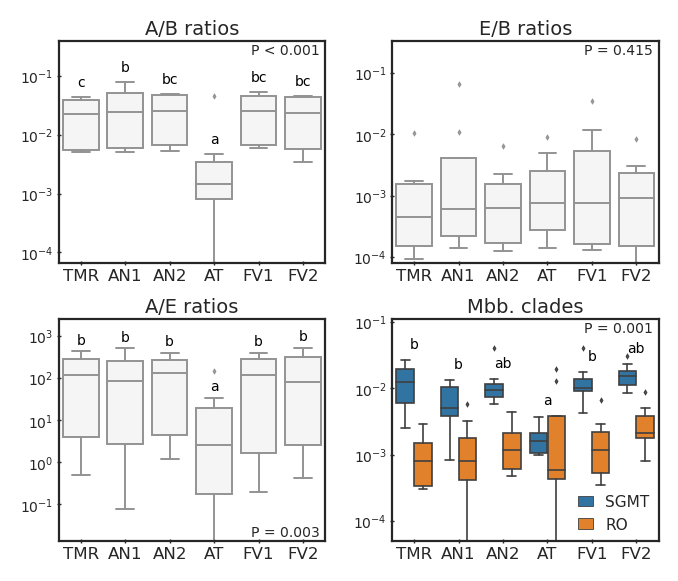

In [33]:
#with anova

META['BS_Trt_Run'] = META['BS'] +'_'+ META['Trt'] +'_'+ META['rstc_run']
# Domains ratios
out = 'Results/Clades'
rats = ['AB_ratios', 'EB_ratios', 'AE_ratios']
doms = pd.read_csv(f'{TABS}/All-domains_rel_table.tsv', 
                   sep='\t', skiprows=1, index_col=0)
doms = doms.T
doms['AB_ratios'] = doms['k_Archaea']/doms['k_Bacteria']
doms['EB_ratios'] = doms['k_Eukaryota']/doms['k_Bacteria']
doms['AE_ratios'] = doms['k_Archaea']/doms['k_Eukaryota']
#doms['EA_ratios'] = doms['k_Eukaryota']/doms['k_Archaea']
doms[['BS', 'Trt', 'Run']] = META[['BS', 'Trt', 'rstc_run']]
doms.replace([np.inf, -np.inf], 0, inplace=True)

#check domain ratios normality
norm = pd.DataFrame(columns=['Metric', 'Stats', 'p'])
for rat in rats:
    data = doms[doms[rat].notna()].copy()
    i = len(norm)
    norm.loc[i, 'Metric'] = rat
    norm.loc[i, ['Stats', 'p']] = stats.shapiro(data[rat])
norm.to_csv(f'{out}/rats_normality.tsv', sep='\t', index=False)
print('Checking normality of ratios')
display(norm)

# Mbb. clades
clades = {
    'SGMT': ['smithii', 'gottschalkii', 'millerae', 'thaueri'],
    'RO': ['ruminantium', 'olleyae']}

rel = pd.read_csv(f'{TABS}/Archaea-species-rel_table.tsv',
                  sep='\t', skiprows=1, index_col=0)
clade_data = pd.DataFrame()
for clade in clades:
    df = rel.loc[[i for i in rel.index if any(s in i for s in clades[clade])]]
    df['clade'] = clade
    clade_data = pd.concat([clade_data, df], axis=0)
clade_data = clade_data.groupby(['clade']).sum().T
clade_data['ratios'] = clade_data['SGMT']/clade_data['RO']
clade_data.replace([np.inf, -np.inf], 0, inplace=True)
clade_data['BS_Trt_Run'] = META['BS_Trt_Run']
clade_df = clade_data.melt(id_vars='BS_Trt_Run', value_vars=['RO', 'SGMT']).copy()
clade_df[['BS', 'Trt', 'Run']] = clade_df.BS_Trt_Run.str.split('_', n=2, expand=True)
clade_data[['BS', 'Trt', 'Run']] = clade_data.BS_Trt_Run.str.split('_', n=2, expand=True)

#check clades ratios normality
norm = pd.DataFrame(columns=['Metric', 'Stats', 'p'])
i = len(norm)
norm.loc[i, 'Metric'] = 'Mbb. clades ratios'
norm.loc[i, ['Stats', 'p']] = stats.shapiro(clade_data['ratios'])
norm.to_csv(f'{out}/Mbb_clades_ratios_normality.tsv', sep='\t', index=False)
print('Checking normality of Mbb. clades ratios')
display(norm)

#get y limits
yAB = [doms['AB_ratios'].min(), doms['AB_ratios'].max()]
yEB = [doms['EB_ratios'].min(), doms['EB_ratios'].max()]
yAE = [doms['AE_ratios'].min(), doms['AE_ratios'].max()]
yMb = [clade_df['value'].min(), clade_df['value'].max()]
ylims = [yAB, yEB, yAE, yMb]

# Declare figure

#get wildth ratios
ratios = [len(clade_df.loc[clade_df.BS==g].Trt.unique()) for g in clade_df.BS.unique()] 
fig, axes = plt.subplots(2, 2, figsize=(3, 2.5), 
           gridspec_kw={'wspace': .25, 'hspace': .25})
axs, i = [[r, c] for r in range(2) for c in range(2)], 0
for ax in axes.reshape(-1):
    ax.tick_params(axis='both', labelsize=5, pad=1, length=1.6, width=.5, direction='inout')
    ax.tick_params(axis='x', labelsize=6)
    
    
    
#domains ratios
for i, rat in enumerate(rats):

    #plot
    ax = axes[axs[i][0]][axs[i][1]]
    ax.set_ylim(ylims[i][0], ylims[i][1]*5)
    ax.set(yscale="log")
    ax.minorticks_off()
    df = doms.loc[doms.BS.isin(['FL', 'FR'])].copy()
    order = [v for v in CDICT if v in df.Trt.unique()]
    sns.boxplot(x='Trt', y=rat, data=df, linewidth=0.7, fliersize=0.3, 
                order=order, color='whitesmoke', ax=ax)
    ax.text(.5, 1.03, f'{rat[0]}/{rat[1]} {rat.split("_")[-1]}', ha='center', fontsize=7, 
            transform=ax.transAxes)
    ax.set_xlabel('')
    ax.set_ylabel('')

    #stats
    formula= f'{rat} ~ BS * Trt + Run'
    anova, pairwise, residuals = run_anova(formula, df)
    anova.to_csv(f'{out}/{st}_{rat}_anova_BS*Trt+Run.tsv', sep='\t')
    pairwise.to_csv(f'{out}/{st}_{rat}_anova_BS*Trt+Run_pairs.tsv', sep='\t')
    residuals.to_csv(f'{out}/{st}_{rat}_anova_BS*Trt+Run_residuals.tsv', sep='\t')
    pairwise = pairwise.loc[~pairwise.index.str.contains('rstc|FL|FR')].copy()
    pairwise['Pair'] = pairwise.index
    pairwise[['Group1', 'Group2']] = pairwise.Pair.str.split('-', expand=True)
    cld = ABCstat(pairwise,'Group1', 'Group2', 'pvalue-fdr_bh')
    p_gen = round(anova.loc['Trt', 'PR(>F)'], 3)
    p = f'P = {p_gen}'
    if p_gen == 0.0:
        p = f'P < 0.001'
    ytxt = .94
    if rat in ['AE_ratios']:
        ytxt = .02
    ax.text(.98, ytxt, p, size=5, transform=ax.transAxes, ha='right')
    if p_gen <= .05:
        for ix, x in enumerate(order):
            y = mpl.cbook.boxplot_stats(df.loc[df.Trt == x][rat])[0]['whishi']
            let = cld.loc[x, 'letters']
            ax.text(ix, y * 1.5, let, size=5, ha='center', color='black')

#rel. ab. of sgmt and ro clades

#plot
i += 1
ax = axes[axs[i][0]][axs[i][1]]
ax.set_ylim(.00005, ylims[j][1]*2.5)
ax.set(yscale="log")
ax.minorticks_off()
df = clade_df.loc[clade_df.BS.isin(['FL', 'FR'])].copy()   
order = [v for v in CDICT if v in df.Trt.unique()]
sns.boxplot(x='Trt', y='value', data=df, ax=ax, linewidth=0.6, fliersize=0.3,
            hue='clade', order=order, hue_order=clades)
ax.set_ylabel('', fontsize=7) 
if st != 'FR': 
    ax.get_legend().remove()
else:                         
    ax.legend(loc=4, frameon=False, fontsize=5.5, handlelength=1, borderpad=.1)
ax.set_xlabel('')
ax.text(.5, 1.03, f'Mbb. clades', ha='center', fontsize=7, transform=ax.transAxes)

#stats
bsdata = clade_data.loc[clade_data.BS.isin(['FL', 'FR'])].copy()  
formula= f'ratios ~ BS * Trt + Run'
anova, pairwise, residuals = run_anova(formula, bsdata)
anova.to_csv(f'{out}/{st}_Mbb_clades_ratios_anova_BS*Trt+Run.tsv', sep='\t')
pairwise.to_csv(f'{out}/{st}_Mbb_clades_ratios_anova_BS*Trt+Run_pairs.tsv', sep='\t')
residuals.to_csv(f'{out}/{st}_Mbb_clades_ratios_anova_BS*Trt+Run_residuals.tsv', sep='\t')
pairwise = pairwise.loc[~pairwise.index.str.contains('rstc|FL|FR')].copy()
pairwise['Pair'] = pairwise.index
pairwise[['Group1', 'Group2']] = pairwise.Pair.str.split('-', expand=True)
cld = ABCstat(pairwise,'Group1', 'Group2', 'pvalue-fdr_bh')
p_gen = round(anova.loc['Trt', 'PR(>F)'], 3)
p = f'P = {p_gen}'
if p_gen == 0.0:
    p = f'P < 0.001'
ax.text(.98, .94, p, size=5, transform=ax.transAxes, ha='right')
#continue
if p_gen <= .05:
    for ix, x in enumerate(order):
        sgmt = df.loc[df.clade=='SGMT']
        ysgmt = mpl.cbook.boxplot_stats(sgmt.loc[sgmt.Trt == x]['value'])[0]['whishi']
        ro = df.loc[df.clade=='RO']
        yro = mpl.cbook.boxplot_stats(ro.loc[ro.Trt == x]['value'])[0]['whishi']                
        let = cld.loc[x, 'letters']
        ax.text(ix, max([ysgmt, yro]) * 1.5, let, size=5, ha='center', color='black')

            
fig.align_labels()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)    
plt.savefig('Figures/Clades/sgmt-ro_ratios_anova-pooled.png',bbox_inches='tight',facecolor="w")

,BS,Feature,KW,Group1,Group2,p,q
0,FL,SGMT,0.011628,TMR,AN1,0.0832645,0.156121
1,FL,SGMT,0.011628,TMR,AN2,0.386476,0.445934
2,FL,SGMT,0.011628,TMR,AT,0.0209213,0.062764
3,FL,SGMT,0.011628,TMR,FV1,0.77283,0.828032
4,FL,SGMT,0.011628,TMR,FV2,1,1
5,FL,SGMT,0.011628,AN1,AN2,0.148915,0.203065
6,FL,SGMT,0.011628,AN1,AT,0.0209213,0.062764
7,FL,SGMT,0.011628,AN1,FV1,0.148915,0.203065
8,FL,SGMT,0.011628,AN1,FV2,0.0433081,0.10827
9,FL,SGMT,0.011628,AN2,AT,0.0209213,0.062764


,BS,Feature,KW,Group1,Group2,p,q
0,FR,SGMT,0.062246,-,-,-,-
1,FR,RO,0.718480,-,-,-,-


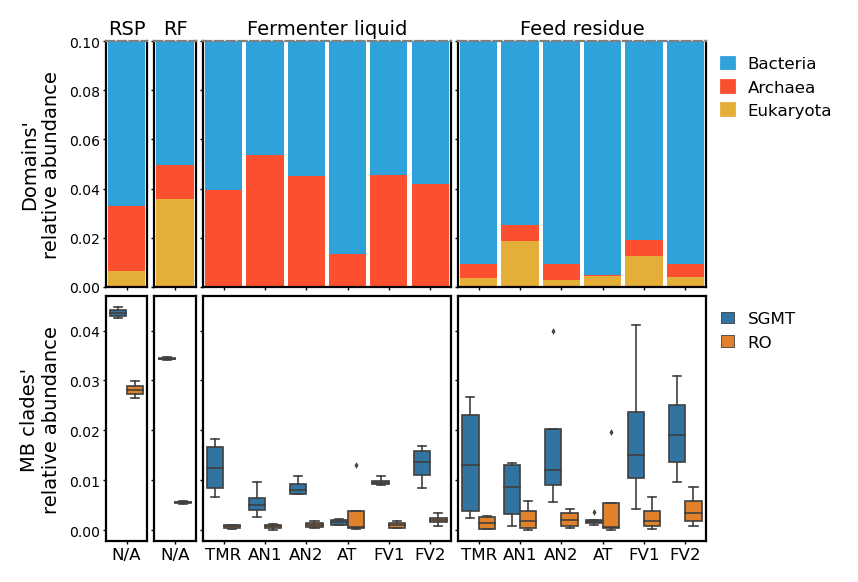

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import sys
sys.path.append('/home/timyerg/Dropbox/TY_scripts')
sys.path.append('/home/meco/Dropbox/TY_scripts')
%matplotlib inline 

plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure


# Kruskal-Wallis general test + Kruskal-Wallis pairwise test for independent samples
def kw_test(df,col,metric,pairs=False,pairwise=True):
    phoc = pd.DataFrame(columns=['Group1','Group2','Mean1','Mean2','Stats','p'])
    kw = stats.kruskal(*[g[metric].values for n,g in df.groupby(col)])
    if kw[1] <= 0.05 and pairwise==True:
        if pairs == False: pairs = combinations(df[col].unique(),2)
        for pair in pairs:
            one,two = df.loc[df[col]==pair[0],metric].tolist(), df.loc[df[col]==pair[1],metric].tolist()
            r,p = stats.kruskal(one,two)
            phoc.loc[len(phoc)]=[pair[0],pair[1],np.median(one),np.median(two),r,p]
        phoc['q'] = multipletests(phoc.p,method='fdr_bh')[1]
    return kw,phoc

#Summarize kw
def summarize(summary,j,kw,group,feat):
    if kw[1] <= 0.05:
        for ind in phoc.index:
            summary.loc[j,'BS'] = group
            summary.loc[j,'Feature'] = feat
            summary.loc[j,'KW'] = kw[1]
            summary.loc[j,'Group1'] = phoc.loc[ind,'Group1']
            summary.loc[j,'Group2'] = phoc.loc[ind,'Group2']
            summary.loc[j,'p'] = phoc.loc[ind,'p']
            summary.loc[j,'q'] = phoc.loc[ind,'q']
            j += 1
    else:
        summary.loc[j,'BS'] = group
        summary.loc[j,'Feature'] = feat
        summary.loc[j,'KW'] = kw[1]
        summary.loc[j,'Group1'] = '-'
        summary.loc[j,'Group2'] = '-'
        summary.loc[j,'p'] = '-'
        summary.loc[j,'q'] = '-'
        j += 1
    return summary,j
                

names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
stypes = {'RSP':'RSP','RF':'RF','FL':'Fermenter liquid','FR':'Feed residue'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)

# Mbb. clades
clades = {'SGMT':['smithii','gottschalkii','millerae','thaueri'],'RO':['ruminantium','olleyae']}
order = [v for v in names.values() if v!='N/A']
horder = list(clades.keys())

rel = pd.read_csv('Data/Tables/Archaea-species-rel_table.tsv',sep='\t',skiprows=1,index_col=0)
clade_data = pd.DataFrame()
for clade in clades:
    df = rel.loc[[i for i in rel.index if any(s in i for s in clades[clade])]]
    df['clade'] = clade
    clade_data = pd.concat([clade_data,df],axis=0)
clade_data = clade_data.groupby(['clade']).sum().T
clade_data['ratios'] = clade_data['SGMT']/clade_data['RO']
clade_data['BS_Trt'] = meta['BS_Trt']
clade_df = clade_data.melt(id_vars='BS_Trt',value_vars=['RO','SGMT']).copy()
clade_df[['BS','Trt']] = clade_df.BS_Trt.str.split('_',expand=True)
clade_data[['BS','Trt']] = clade_data.BS_Trt.str.split('_',expand=True)

# Declare figure
ratios = [len(clade_df.loc[clade_df.BS==g].Trt.unique()) for g in clade_df.BS.unique()] #get wildth ratios
fig,axes = plt.subplots(2, 4, figsize=(3, 2.5), sharey='row', sharex='col',
           gridspec_kw={'wspace': .05, 'hspace': .04, 'width_ratios': ratios})
axs,i = [[r,c] for r in range(2) for c in range(4)],0


legend = []
df = taxamod(bar_unzip('Results/Taxabarplots/All-barplot.qzv',1),1)
df = df.groupby(level=0,axis=1).sum() #sum duplicates
df.loc['mean'] = df.mean() #add a row with mean 
df.sort_values(inplace=True,axis=1,by='mean',ascending=True)#sort features by sum of abundances
df.drop(inplace=True,index='mean')
df = df.div(df.sum(axis=1),axis=0) #convert to rel ab
md = meta.loc[df.index.tolist(),:].copy() #remove filtered samples from metadata 
md = md.sort_values(['Day_num','BS','Treatment'],ascending=[True,True,True]) #sort df

cdict = dict(zip(df.columns.tolist()[::-1], colours)) #create a colorbar for legend
data = pd.DataFrame() #store mean rel ab by sample-type, day and treatment
for g in md.BS_Trt.unique():
    tempmet = md.loc[md.BS_Trt==g].copy()
    tempdf = df.copy().drop([i for i in df.index if i not in tempmet.index])
    for col in tempdf.columns:
        data.loc[g,col]=tempdf[col].mean()
for col in data.columns: # remove low abundant features 
    if data[col].max() < .03: 
        data = data.drop(col,axis=1)
for i,group in enumerate(stypes): #iterate through sample-types by days
    ax1 = axes[axs[i][0]][axs[i][1]]
    submet = md.loc[md.BS==group].copy()
    subdata = data.loc[[j for j in data.index if j in submet.BS_Trt.tolist()],:] #data to plot
    subdata.index = subdata.index.str.replace('_d0_N/A','').str.split('_').str[-1]
    if 'TMR' in subdata.index:
        subdata = subdata.reindex(['TMR','AN1','AN2','AT','FV1','FV2'])
    bottom = [1-subdata.loc[j,:].sum() for j in subdata.index]
    for col in subdata.columns: # iterate through all features
        c = cdict[col]
        if col not in legend: legend = [col]+legend
        ax1.bar(x=subdata.index,height=subdata[col],bottom=bottom,color=c,label=col,width=0.9,linewidth=.0)
        bottom = [a+b for a,b in zip(bottom, subdata[col].tolist())]    
    ax1.tick_params(axis='both',labelsize=8,pad=0.5,length=0,width=0.2) # adjust ticks
    ax1.tick_params(axis='x',labelrotation=90,length=1,labelsize=9) # adjust ticks
    ax1.set_ylim(0,.1) # set limit for y axis
    ax1.set_xlim(-0.5,len(subdata.index)-0.5)
    ax1.set_ylabel("Domains'\nrelative abundance", fontsize=7,labelpad=3)
    ax1.text(0.5,1.03,stypes[group.split('_')[0]],ha='center',fontsize=7,transform=ax1.transAxes)
    plt.setp(list(ax1.spines.values())[3], color='grey',ls='--') # set color and style for upper line
    if i == len(ratios)-1:
        labels = [f for f in data.columns[::-1] if f in legend]
 #if dom == 'bac': labels += ['others']                     
        handles = [mpatches.Patch(fill=False,edgecolor='none',visible=False) if l == 'others' \
                             else mpatches.Patch(color=cdict[l],label=l) for l in labels]
        ypos = 1
        leg = ax1.legend(handles,labels,loc=2,bbox_to_anchor=(1,ypos),fontsize=6,frameon=False,
                         handlelength=0.8,bbox_transform=ax1.transAxes)  

    
 #rel. ab. of sgmt and ro clades and stat analysis
    ax2 = axes[axs[i+len(ratios)][0]][axs[i+len(ratios)][1]]
    df = clade_df.loc[clade_df.BS==group].copy()
    
    if group in ['FL','FR']:
        summary,j = pd.DataFrame(),0
        for feat in 'SGMT','RO':
            bsdata = df.loc[(df.clade==feat)].copy()
            kw,phoc = kw_test(bsdata.copy(),'Trt','value')
            summary,j = summarize(summary,j,kw,group,feat)

        summary.to_csv('Results/Clades/Clades_%s_Treatments.tsv'%group,sep='\t')
 #ax1.text(.99,.93,'P '+str(round(summary['KW'].min(),3)),size=5,transform=ax1.transAxes,ha='right')
        display(summary)    
    order = [v for v in names.values() if v in df.Trt.unique()]
    horder = list(clades.keys())
    sns.boxplot(x='Trt',y='value',data=df,ax=ax2,linewidth=0.6,fliersize=0.3,hue='clade',order=order,hue_order=horder)
    ax2.set_ylabel("MB clades'\nrelative abundance",fontsize=7,labelpad=3) 
    if group != 'FR': ax2.get_legend().remove()
    else:                         
        ax2.legend(loc=2,frameon=False,fontsize=6,bbox_to_anchor=(1,ypos),handlelength=0.8,)
    
        
    for ax in ax1, ax2:
        ax.tick_params(axis='both', labelsize=5, pad=1, length=1, width=0.5) # adjust ticks
        ax.tick_params(axis='x', labelsize=6) # adjust ticks
        ax.set_xlabel('')
        if group != 'RSP': 
            ax.set_ylabel('')

fig.align_labels()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)    
plt.savefig('Figures/Clades/Domains_and_sgmt-ro_ratios.png',bbox_inches='tight',facecolor="w")

In [24]:
ratios

[1, 1, 6, 6]

# Core-metrics

In [3]:
domains = {'Bacteria':26525344,'Archaea':78731}
outdir = 'Results/Core-metrics'

!mkdir -p $outdir
for dom in domains:
    depth = domains[dom]
    
    !qiime diversity core-metrics \
        --i-table Data/Tables/$dom-species-table.qza \
        --p-sampling-depth $depth \
        --m-metadata-file metadata.tsv \
        --p-n-jobs-or-threads 'auto' \
        --output-dir $outdir/$dom

Saved FeatureTable[Frequency] to: Results/Core-metrics/Bacteria/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Results/Core-metrics/Bacteria/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Results/Core-metrics/Bacteria/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Results/Core-metrics/Bacteria/evenness_vector.qza
Saved DistanceMatrix to: Results/Core-metrics/Bacteria/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Results/Core-metrics/Bacteria/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Core-metrics/Bacteria/jaccard_pcoa_results.qza
Saved PCoAResults to: Results/Core-metrics/Bacteria/bray_curtis_pcoa_results.qza
Saved Visualization to: Results/Core-metrics/Bacteria/jaccard_emperor.qzv
Saved Visualization to: Results/Core-metrics/Bacteria/bray_curtis_emperor.qzv
Saved FeatureTable[Frequency] to: Results/Core-metrics/Archaea/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Results/Core-metrics/Archaea/observed_features_ve

In [8]:
#divide alpha metrics by bs
import pandas as pd

def alpha_div(qza):    
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/alpha-diversity.tsv'
    data = pd.read_csv(inf, sep='\t',index_col=0)
    !rm -r $digest
    return data 

alphas = ['shannon', 'evenness', 'observed_features']
md = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
for dom in ['Bacteria','Archaea']:
    for bs in md.BS.unique():
        for alpha in alphas:
            vec = alpha_div('Results/Core-metrics/%s/%s_vector.qza' % (dom,alpha))
            qza = 'Results/Core-metrics/%s/%s_%s_vector.qza' % (dom,bs,alpha)
            meta = md.loc[md.BS==bs].copy()
            data = vec[vec.index.isin(meta.index.tolist())].copy() # remove missing samples from vector
            meta = meta[meta.index.isin(data.index.tolist())] # remove missing samples from metadata
            md.loc[md.BS==bs,alpha+'_'+dom] = data[data.columns.tolist()[0]]# add alpha diversity to metadata
md.to_csv('metadata.tsv',sep='\t')

In [9]:
#divide beta metrics by bs
import pandas as pd

md = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
for dom in ['Bacteria','Archaea']:
    for bs in md.BS.unique():
        if bs in ['RSP','RF']: continue
        for dist in ['jaccard','bray_curtis']:
            distin = 'Results/Core-metrics/%s/%s_distance_matrix.qza' % (dom,dist)
            distex = 'Results/Core-metrics/%s/%s_%s_distance_matrix.qza' % (dom,bs,dist)
            pcoa = 'Results/Core-metrics/%s/%s_%s_pcoa_results.qza' % (dom,bs,dist)
            plot = 'Results/Core-metrics/%s/%s_%s_emperor.qzv' % (dom,bs,dist)
            meta = md.loc[md.BS==bs].copy()
            meta.to_csv('Data/%s-%s-metadata.tsv'%(dom,bs),sep='\t')
            
            !qiime diversity filter-distance-matrix \
                --i-distance-matrix $distin \
                --m-metadata-file Data/$dom-$bs-metadata.tsv \
                --o-filtered-distance-matrix $distex

            !qiime diversity pcoa \
                --i-distance-matrix $distex \
                --o-pcoa $pcoa

            !qiime emperor plot \
                --i-pcoa $pcoa \
                --m-metadata-file Data/$dom-$bs-metadata.tsv \
                --o-visualization $plot

Saved DistanceMatrix to: Results/Core-metrics/Bacteria/FR_jaccard_distance_matrix.qza
Saved PCoAResults to: Results/Core-metrics/Bacteria/FR_jaccard_pcoa_results.qza
Saved Visualization to: Results/Core-metrics/Bacteria/FR_jaccard_emperor.qzv
Saved DistanceMatrix to: Results/Core-metrics/Bacteria/FR_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Core-metrics/Bacteria/FR_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/Core-metrics/Bacteria/FR_bray_curtis_emperor.qzv
Saved DistanceMatrix to: Results/Core-metrics/Bacteria/FL_jaccard_distance_matrix.qza
Saved PCoAResults to: Results/Core-metrics/Bacteria/FL_jaccard_pcoa_results.qza
Saved Visualization to: Results/Core-metrics/Bacteria/FL_jaccard_emperor.qzv
Saved DistanceMatrix to: Results/Core-metrics/Bacteria/FL_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Core-metrics/Bacteria/FL_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/Core-metrics/Bacteria/FL_bray_curtis_emperor.qzv
Save

# Beta diversity stats, Biplots and figures

## q2-Biplots

In [1]:
# Biplots by diversity (all)
import pandas as pd

md = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
for dom in ['Archaea','Bacteria']:
    tabrar = 'Results/Core-metrics/%s/rarefied_table.qza' % dom
    tabrel = 'Results/Core-metrics/%s/relative_table.qza' % dom
    outdir = 'Results/Biplots/%s/' % dom
    
 # Converting rarefied feature table [Frequency] to [Relative frequency]
    !qiime feature-table relative-frequency \
        --i-table $tabrar \
        --o-relative-frequency-table $tabrel
        
    !mkdir -p $outdir
    for dist in ['jaccard', 'bray_curtis']:
        pcoa = 'Results/Core-metrics/%s/%s_pcoa_results.qza' % (dom,dist)
        biplot = outdir + '/%s_biplot.qza' % dist
        bi_qzv = outdir + '/%s_biplot.qzv' % dist

 # pcoa-biplot: Principal Coordinate Analysis Biplot         
        !qiime diversity pcoa-biplot \
            --i-pcoa $pcoa \
            --i-features $tabrel \
            --o-biplot $biplot

        !qiime emperor biplot \
            --i-biplot $biplot \
            --m-sample-metadata-file metadata.tsv \
            --p-ignore-missing-samples \
            --p-number-of-features 5 \
            --o-visualization $bi_qzv

Saved FeatureTable[RelativeFrequency] to: Results/Core-metrics/Archaea/relative_table.qza
Saved PCoAResults % Properties('biplot') to: Results/Biplots/Archaea//jaccard_biplot.qza
Saved Visualization to: Results/Biplots/Archaea//jaccard_biplot.qzv
Saved PCoAResults % Properties('biplot') to: Results/Biplots/Archaea//bray_curtis_biplot.qza
Saved Visualization to: Results/Biplots/Archaea//bray_curtis_biplot.qzv
Saved FeatureTable[RelativeFrequency] to: Results/Core-metrics/Bacteria/relative_table.qza
Saved PCoAResults % Properties('biplot') to: Results/Biplots/Bacteria//jaccard_biplot.qza
Saved Visualization to: Results/Biplots/Bacteria//jaccard_biplot.qzv
Saved PCoAResults % Properties('biplot') to: Results/Biplots/Bacteria//bray_curtis_biplot.qza
Saved Visualization to: Results/Biplots/Bacteria//bray_curtis_biplot.qzv


In [2]:
# Biplots by BS
import pandas as pd

md = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
for dom in ['Bacteria','Archaea']:
    tabrar = 'Results/Core-metrics/%s/rarefied_table.qza' % dom
    tabrel = 'Results/Core-metrics/%s/relative_table.qza' % dom
    
 # Converting rarefied feature table [Frequency] to [Relative frequency]
    !qiime feature-table relative-frequency \
        --i-table $tabrar \
        --o-relative-frequency-table $tabrel
    
    for bs in md.BS.unique():
        if bs in ['RSP','RF']: continue
        tabfil = 'Results/Core-metrics/%s/%s_rel_table.qza' % (dom,bs)
        outdir = 'Results/Biplots/%s_%s/' % (dom,bs)
        
 #filter by bs
        !qiime feature-table filter-samples \
            --i-table $tabrel \
            --m-metadata-file Data/$dom-$bs-metadata.tsv \
            --o-filtered-table $tabfil
        
        !mkdir -p $outdir
        for dist in ['jaccard', 'bray_curtis']:
            pcoa = 'Results/Core-metrics/%s/%s_%s_pcoa_results.qza' % (dom,bs,dist)
            biplot = outdir + '/%s_biplot.qza' % dist
            bi_qzv = outdir + '/%s_biplot.qzv' % dist

 # pcoa-biplot: Principal Coordinate Analysis Biplot         
            !qiime diversity pcoa-biplot \
                --i-pcoa $pcoa \
                --i-features $tabfil \
                --o-biplot $biplot

            !qiime emperor biplot \
                --i-biplot $biplot \
                --m-sample-metadata-file Data/$dom-$bs-metadata.tsv \
                --p-ignore-missing-samples \
                --p-number-of-features 5 \
                --o-visualization $bi_qzv

Saved FeatureTable[RelativeFrequency] to: Results/Core-metrics/Bacteria/relative_table.qza
Saved FeatureTable[RelativeFrequency] to: Results/Core-metrics/Bacteria/FR_rel_table.qza
Saved PCoAResults % Properties('biplot') to: Results/Biplots/Bacteria_FR//jaccard_biplot.qza
Saved Visualization to: Results/Biplots/Bacteria_FR//jaccard_biplot.qzv
Saved PCoAResults % Properties('biplot') to: Results/Biplots/Bacteria_FR//bray_curtis_biplot.qza
Saved Visualization to: Results/Biplots/Bacteria_FR//bray_curtis_biplot.qzv
Saved FeatureTable[RelativeFrequency] to: Results/Core-metrics/Bacteria/FL_rel_table.qza
Saved PCoAResults % Properties('biplot') to: Results/Biplots/Bacteria_FL//jaccard_biplot.qza
Saved Visualization to: Results/Biplots/Bacteria_FL//jaccard_biplot.qzv
Saved PCoAResults % Properties('biplot') to: Results/Biplots/Bacteria_FL//bray_curtis_biplot.qza
Saved Visualization to: Results/Biplots/Bacteria_FL//bray_curtis_biplot.qzv
Saved FeatureTable[RelativeFrequency] to: Results/Core-

## PERMANOVA

In [6]:
import pandas as pd

#unpack output file
def adon_ext(qza):    
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ','')
    ado = pd.read_csv(out+'/data/adonis.tsv',sep='\t')
    !rm -r $out
    return ado

def perm_ext(qza):    
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ','')
    ind = pd.read_html(out+'/data/index.html')[0]
    pws = pd.read_csv(out+'/data/permanova-pairwise.csv')
    raw = pd.read_csv(out+'/data/raw_data.tsv',sep='\t',index_col=0)
    !rm -r $out
    return ind,pws,raw

#function to perform Adonis test
def adonis(qza,formula,qzv):
    !qiime diversity adonis \
        --i-distance-matrix $qza \
        --m-metadata-file metadata.tsv \
        --p-formula $formula \
        --p-n-jobs 4 \
        --o-visualization $qzv

#function to perform PERMANOVA test
def permanova(qza,col,qzv):
    !qiime diversity beta-group-significance \
        --i-distance-matrix $qza \
        --m-metadata-file metadata.tsv \
        --m-metadata-column $col \
        --p-pairwise \
        --o-visualization $qzv

adodir = 'Results/Adonis/'
permdir = 'Results/Permanova/'
domains = ['Archaea','Bacteria']
bss = ['FL','FR']
betas = ['bray_curtis']

!mkdir -p $adodir $permdir

## Beta group significance (one-way PERMANOVA)

In [4]:
!pip install lxml
!pip install html5lib

In [7]:
# Test BS with full tables
cols = ['BS'] #cols to test
summary,i = pd.DataFrame(),0 #summarize outputs

for dom in domains:
    coremet = 'Results/Core-metrics/%s/' % dom
    for beta in betas:
        qza = coremet+'%s_distance_matrix.qza' % beta
        for col in cols:
            qzv = permdir+'%s_%s_%s.qzv' % (dom,beta,col)
            permanova(qza,col,qzv) #run permanova in q2
            ind,pws,raw = perm_ext(qzv) #unpack
            summary.loc[i,'Domain'] = dom
            summary.loc[i,'Metric'] = beta
            summary.loc[i,'BS'] = 'Pooled'
            summary.loc[i,'Column'] = col
            summary.loc[i,'Method'] = 'Omnibus'
            summary.loc[i,'p-omnibus'] = float(ind['PERMANOVA results'][5])
            summary.loc[i,'Group1'] = '-'
            summary.loc[i,'Group2'] = '-'
            summary.loc[i,'Sample size'] = float(ind['PERMANOVA results'][2])
            summary.loc[i,'Groups'] = float(ind['PERMANOVA results'][3])
            summary.loc[i,'Pseudo-F'] = float(ind['PERMANOVA results'][4])
            summary.loc[i,'Permutations'] = float(ind['PERMANOVA results'][6])
            summary.loc[i,'p-value'] = '-'
            summary.loc[i,'q-value'] = '-'
            i += 1
            if len(pws) > 1:
                for j in pws.index:
                    summary.loc[i,'Domain'] = dom
                    summary.loc[i,'Metric'] = beta
                    summary.loc[i,'BS'] = 'Pooled'
                    summary.loc[i,'Column'] = col
                    summary.loc[i,'Method'] = 'Pairwise'
                    summary.loc[i,'p-omnibus'] = '-'
                    summary.loc[i,'Group1'] = pws.loc[j,'Group 1']
                    summary.loc[i,'Group2'] = pws.loc[j,'Group 2']
                    summary.loc[i,'Sample size'] = pws.loc[j,'Sample size']
                    summary.loc[i,'Groups'] = '-'
                    summary.loc[i,'Pseudo-F'] = pws.loc[j,'pseudo-F']
                    summary.loc[i,'Permutations'] = pws.loc[j,'Permutations']
                    summary.loc[i,'p-value'] = pws.loc[j,'p-value']
                    summary.loc[i,'q-value'] = pws.loc[j,'q-value']
                    i += 1        
            !rm $qzv
display(summary)             
summary.to_csv(permdir+'Pooled_BS.tsv',sep='\t')

Saved Visualization to: Results/Permanova/Archaea_bray_curtis_BS.qzv
Saved Visualization to: Results/Permanova/Bacteria_bray_curtis_BS.qzv


,Domain,Metric,BS,Column,Method,p-omnibus,Group1,Group2,Sample size,Groups,Pseudo-F,Permutations,p-value,q-value
0,Archaea,bray_curtis,Pooled,BS,Omnibus,0.001,-,-,50.0,4,7.009760,999.0,-,-
1,Archaea,bray_curtis,Pooled,BS,Pairwise,-,FL,FR,46.0,-,5.223268,999.0,0.001,0.006
2,Archaea,bray_curtis,Pooled,BS,Pairwise,-,FL,RF,26.0,-,7.958472,999.0,0.011,0.0156
3,Archaea,bray_curtis,Pooled,BS,Pairwise,-,FL,RSP,26.0,-,10.369432,999.0,0.01,0.0156
4,Archaea,bray_curtis,Pooled,BS,Pairwise,-,FR,RF,24.0,-,5.610923,999.0,0.013,0.0156
5,Archaea,bray_curtis,Pooled,BS,Pairwise,-,FR,RSP,24.0,-,7.806553,999.0,0.006,0.0156
6,Archaea,bray_curtis,Pooled,BS,Pairwise,-,RF,RSP,4.0,-,18.010001,999.0,0.312,0.312
7,Bacteria,bray_curtis,Pooled,BS,Omnibus,0.001,-,-,52.0,4,38.579600,999.0,-,-
8,Bacteria,bray_curtis,Pooled,BS,Pairwise,-,FL,FR,48.0,-,92.048691,999.0,0.001,0.0045
9,Bacteria,bray_curtis,Pooled,BS,Pairwise,-,FL,RF,26.0,-,18.516959,999.0,0.003,0.0045


In [8]:
# Test Treatment by BS and Treatment
cols = ['Treatment'] #cols to test
summary,i = pd.DataFrame(),0 #summarize outputs

for dom in domains:
    coremet = 'Results/Core-metrics/%s/' % dom
    for bs in bss:
        for beta in betas:
            qza = coremet+'%s_%s_distance_matrix.qza' % (bs,beta)
            for col in cols:
                qzv = permdir+'%s_%s_%s_%s.qzv' % (dom,bs,beta,col)
                permanova(qza,col,qzv) #run permanova in q2
                ind,pws,raw = perm_ext(qzv) #unpack
                summary.loc[i,'Domain'] = dom
                summary.loc[i,'Metric'] = beta
                summary.loc[i,'BS'] = bs
                summary.loc[i,'Column'] = col
                summary.loc[i,'Method'] = 'Omnibus'
                summary.loc[i,'p-omnibus'] = float(ind['PERMANOVA results'][5])
                summary.loc[i,'Group1'] = '-'
                summary.loc[i,'Group2'] = '-'
                summary.loc[i,'Sample size'] = float(ind['PERMANOVA results'][2])
                summary.loc[i,'Groups'] = float(ind['PERMANOVA results'][3])
                summary.loc[i,'Pseudo-F'] = float(ind['PERMANOVA results'][4])
                summary.loc[i,'Permutations'] = float(ind['PERMANOVA results'][6])
                summary.loc[i,'p-value'] = '-'
                summary.loc[i,'q-value'] = '-'
                i += 1
                if len(pws) > 1:
                    for j in pws.index:
                        summary.loc[i,'Domain'] = dom
                        summary.loc[i,'Metric'] = beta
                        summary.loc[i,'BS'] = bs
                        summary.loc[i,'Column'] = col
                        summary.loc[i,'Method'] = 'Pairwise'
                        summary.loc[i,'p-omnibus'] = '-'
                        summary.loc[i,'Group1'] = pws.loc[j,'Group 1']
                        summary.loc[i,'Group2'] = pws.loc[j,'Group 2']
                        summary.loc[i,'Sample size'] = pws.loc[j,'Sample size']
                        summary.loc[i,'Groups'] = '-'
                        summary.loc[i,'Pseudo-F'] = pws.loc[j,'pseudo-F']
                        summary.loc[i,'Permutations'] = pws.loc[j,'Permutations']
                        summary.loc[i,'p-value'] = pws.loc[j,'p-value']
                        summary.loc[i,'q-value'] = pws.loc[j,'q-value']
                        i += 1        
                !rm $qzv
display(summary)             
summary.to_csv(permdir+'BS_Treatment.tsv',sep='\t')

Saved Visualization to: Results/Permanova/Archaea_FL_bray_curtis_Treatment.qzv
Saved Visualization to: Results/Permanova/Archaea_FR_bray_curtis_Treatment.qzv
Saved Visualization to: Results/Permanova/Bacteria_FL_bray_curtis_Treatment.qzv
Saved Visualization to: Results/Permanova/Bacteria_FR_bray_curtis_Treatment.qzv


,Domain,Metric,BS,Column,Method,p-omnibus,Group1,Group2,Sample size,Groups,Pseudo-F,Permutations,p-value,q-value
0,Archaea,bray_curtis,FL,Treatment,Omnibus,0.001,-,-,24.0,6,5.919450,999.0,-,-
1,Archaea,bray_curtis,FL,Treatment,Pairwise,-,Trt1,Trt2,8.0,-,0.886529,999.0,0.477,0.550385
2,Archaea,bray_curtis,FL,Treatment,Pairwise,-,Trt1,Trt3,8.0,-,0.164933,999.0,0.892,0.892
3,Archaea,bray_curtis,FL,Treatment,Pairwise,-,Trt1,Trt4,8.0,-,8.640889,999.0,0.025,0.09
4,Archaea,bray_curtis,FL,Treatment,Pairwise,-,Trt1,Trt5,8.0,-,1.133200,999.0,0.32,0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Bacteria,bray_curtis,FR,Treatment,Pairwise,-,Trt3,Trt5,8.0,-,0.709937,999.0,0.664,0.8625
60,Bacteria,bray_curtis,FR,Treatment,Pairwise,-,Trt3,Trt6,8.0,-,0.376293,999.0,0.725,0.8625
61,Bacteria,bray_curtis,FR,Treatment,Pairwise,-,Trt4,Trt5,8.0,-,0.952539,999.0,0.382,0.8625
62,Bacteria,bray_curtis,FR,Treatment,Pairwise,-,Trt4,Trt6,8.0,-,1.939936,999.0,0.199,0.8625


## Figures

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import euclidean
%matplotlib inline

plt.rcParams['axes.linewidth'] = .5 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure
sns.set_style("ticks")

def parse_biplot(qza): ### Unzipping qza biplots
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ','')
    inf = digest + '/data/ordination.txt'
    lines = open(inf,'r').readlines()
    Eigvals = [float(i) for i in lines[1].rstrip().split('\t')]
    Proportion = [float(i) for i in lines[4].rstrip().split('\t')]
    bpl_skipr = 7
    bpl_skipf = len(open(inf,'r').read().split('Site')[1].splitlines()) + 1
    pca_skipr = len(open(inf,'r').read().split('Site')[0].splitlines()) + 1
    pca_skipf = 4
    pcoa = pd.read_csv(inf,index_col=0,skiprows=pca_skipr,skipfooter=pca_skipf,header=None,sep='\t',engine='python')
    biplot = pd.read_csv(inf,index_col=0,skiprows=bpl_skipr,skipfooter=bpl_skipf,header=None,sep='\t',engine='python')
    !rm -r $digest
    return    pcoa, biplot, Eigvals, Proportion

def get_arrow_coords(axis,axis2,num,biplot): ### Geting coordinats for arrows
    arrow_data = []
    origin = np.zeros_like(biplot.columns)
    biplot['importance'] = biplot.apply(euclidean, axis=1, args=(origin,))
    biplot.sort_values('importance', inplace=True, ascending=False)
    for taxon in biplot.index.tolist()[:num].copy():
        arrow_data.append([taxon,biplot.at[taxon,axis]/2,biplot.at[taxon,axis2]/2])
    return arrow_data
                
diversity = {'bray_curtis':'Bray-Curtis'}
domains = ['Archaea','Bacteria']
mdict = {'RF':'d', 'RSP':'s', 'FL':'p', 'FR':'X'}
sizes = {'d0':10,'d13':40}
cdict = {'TMR':'grey','AN1':'limegreen','AN2':'green','AT':'red',\
                 'FV1':'deepskyblue','FV2':'blue','N/A':'whitesmoke'}

!mkdir -p Figures/Beta_diversity

### All sample-types by treatments

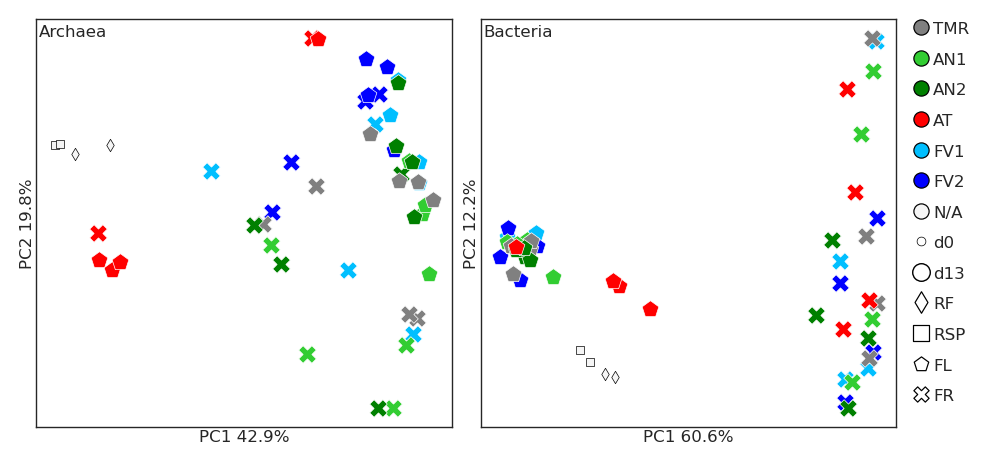

In [13]:
def sub():
    for bs in set(pca_meta.BS):
        for d in set(pca_meta.Day):
            for trt in set(pca_meta.Treatment):
                c = cdict[trt]
                m = mdict[bs]
                s = sizes[d]
                ec = 'white'
                if bs in ['RF','RSP']: ec = 'black'
                df = ordin.loc[ordin.index.isin(pca_meta.loc[((pca_meta.BS==bs)&(pca_meta.Day==d)&(pca_meta.Treatment==trt))].index)]
                sns.scatterplot(x=x,y=y,data=df,ax=ax,color=c,marker=m,s=s,linewidth=0.25,legend=True,edgecolor=ec)

# Creating a scatterplots *********************************************************
fig, axes = plt.subplots(1,3,figsize=(6,2.7),gridspec_kw={'hspace':.1,'wspace':.1,'width_ratios':[1,1,.1]})
#axs,i = [[row,col] for row in range(2) for col in range(2)],0
biplot_features = set()
z,i = 5,0 # Number of features to plot and axis numerator
x,y = 1,2 # axes to plot

names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)

for i,dom in enumerate(domains):
    for beta in diversity:
 #for bs in bss:
            ordin,biplot,Eigvals,Prop = parse_biplot('Results/Biplots/%s/%s_biplot.qza'%(dom,beta))
            pca_meta = meta.fillna('N/A').loc[meta.index.isin(ordin.index)].copy()
            ax, i = axes[i], i+1
            sub() #plot scatterplot by function
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylabel('PC%i %.1f%%'%(y,Prop[y-1]*100.0),fontdict={'fontsize':6},labelpad=.5)
            ax.set_xlabel('PC%i %.1f%%'%(x,Prop[x-1]*100.0),fontdict={'fontsize':6},labelpad=.8)
            ax.annotate(dom,xy=(0,1),xycoords="axes fraction",xytext=(1,-6),textcoords="offset points",size=6)
        
# legend
#[axes[ax[0]][ax[1]].axis('off') for ax in [[0,2],[1,2]]]
ax = axes[-1]
ax.axis('off')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
step = .075
yax, xax = .98, -.1

for c in cdict: #colors
    sns.scatterplot(x=[xax],y=[yax],marker='o',color=cdict[c],ax=ax,s=30,legend=False,edgecolor='black',clip_on=False)
    ax.text(xax+.3,yax-.015,c,fontdict={'size':6})
    yax -= step
    
for s in sizes: #sizes
    sns.scatterplot(x=[xax],y=[yax],marker='o',color='white',ax=ax,s=sizes[s],legend=False,edgecolor='black',clip_on=False)
    ax.text(xax+.3,yax-.015,s,fontdict={'size':6})
    yax -= step
    
for m in mdict: #markers
    sns.scatterplot(x=[xax],y=[yax],marker=mdict[m],color='white',ax=ax,s=30,legend=False,edgecolor='black',clip_on=False)
    ax.text(xax+.3,yax-.015,m,fontdict={'size':6})
    yax -= step

plt.savefig('Figures/Beta_diversity/Bray-Curtis_PCoA.png', bbox_inches='tight',facecolor='w')

# Alpha diversity stats and figures

In [25]:
!conda install -y -c conda-forge statannot

Solving environment: done

# All requested packages already installed.



In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statannot import add_stat_annotation
from itertools import combinations
%matplotlib inline
sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .5 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

# Kruskal-Wallis general test + Kruskal-Wallis pairwise test for independent samples
def kw_test(df,col,metric,pairs,pairwise):
    phoc = pd.DataFrame(columns=['Group1','Group2','Median1','Median2','Stats','p'])
    kw = stats.kruskal(*[g[metric].values for n,g in df.groupby(col)])
    if pairwise==True:
        if pairs == False: pairs = combinations(df[col].unique(),2)
        for pair in pairs:
            one,two = df.loc[df[col]==pair[0],metric].tolist(), df.loc[df[col]==pair[1],metric].tolist()
            r,p = stats.kruskal(one,two)
            phoc.loc[len(phoc)]=[pair[0],pair[1],np.median(one),np.median(two),r,p]
        if len(phoc) > 0: phoc['q'] = multipletests(phoc.p,method='fdr_bh')[1]
    return kw,phoc

# Kruskal-Wallis general test + Wilcoxon pairwise test for dependent samples
def wlcx_test(df,col,metric,ID,states,pairwise):
    phoc = pd.DataFrame(columns=['Group1','Group2','Stats','p'])
    kw = stats.kruskal(*[g[metric].values for n,g in df.groupby(col)])
    if pairwise==True:
        if states == False: states = combinations(df[col].unique(),2)
        for state in states:
            data = df.loc[df[col].isin(state)].copy()
            data = data.pivot_table(index=[ID],columns=col,values=metric)
            r,p = stats.wilcoxon(data[data.columns[0]],data[data.columns[1]])
            phoc.loc[len(phoc)]=[state[0],state[1],r,p]
        if len(phoc) > 0: phoc['q'] = multipletests(phoc.p,method='fdr_bh')[1]
    return kw,phoc

def color_df(df):
    dfcol = df.style.applymap(lambda x: "background-color: red" if x<=0.05 \
    else "background-color: grey",subset=pd.IndexSlice[:, [c for c in df.columns if c in 'pq']])
    return dfcol

domains = ['Archaea','Bacteria']
alphas = {'shannon':'Shannon entropy','evenness':"Pielou\'s evenness",'observed_features':'Observed\nASVs'}
bss = ['RSP','RF','FL','FR']
cdict = {'TMR':'grey','AN1':'limegreen','AN2':'green','AT':'red',\
                 'FV1':'deepskyblue','FV2':'blue','N/A':'whitesmoke'}

!mkdir -p Results/Alpha_test Figures/Alpha_diversity

## BS

In [18]:
#Kruskal-Wallis and Kruskal-Wallis tests, BS
summary,i = pd.DataFrame(),0
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)

for dom in domains:
    col = 'BS' # categorical column to test
    for alpha in alphas: # numerical column to test
        alpha += '_'+dom
        meta = md[md[alpha].notna()].copy()
        kw,phoc = kw_test(meta,col,alpha,False,True)
        if kw[1] <= 0.05:
            for ind in phoc.index:
                summary.loc[i,'Domain'] = dom
                summary.loc[i,'Metric'] = alpha
                summary.loc[i,'p_gen'] = kw[1]
                summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                summary.loc[i,'p'] = phoc.loc[ind,'p']
                summary.loc[i,'q'] = phoc.loc[ind,'q']
                i += 1
        else:
            summary.loc[i,'Domain'] = dom
            summary.loc[i,'Metric'] = alpha
            summary.loc[i,'p_gen'] = kw[1]
            summary.loc[i,'Group1'] = '-'
            summary.loc[i,'Group2'] = '-'
            summary.loc[i,'p'] = '-'
            summary.loc[i,'q'] = '-'
            i += 1
display(summary)
summary.to_csv('Results/Alpha_test/Alpha_KW_BS.tsv',sep='\t')

,Domain,Metric,p_gen,Group1,Group2,p,q
0,Archaea,shannon_Archaea,3.797974e-02,RSP,RF,0.121335,0.182003
1,Archaea,shannon_Archaea,3.797974e-02,RSP,FR,0.0367139,0.110142
2,Archaea,shannon_Archaea,3.797974e-02,RSP,FL,0.034264,0.110142
3,Archaea,shannon_Archaea,3.797974e-02,RF,FR,0.29627,0.29627
4,Archaea,shannon_Archaea,3.797974e-02,RF,FL,0.289839,0.29627
5,Archaea,shannon_Archaea,3.797974e-02,FR,FL,0.0785439,0.157088
6,Archaea,evenness_Archaea,3.453860e-02,RSP,RF,0.121335,0.177932
7,Archaea,evenness_Archaea,3.453860e-02,RSP,FR,0.0367139,0.162875
8,Archaea,evenness_Archaea,3.453860e-02,RSP,FL,0.0542918,0.162875
9,Archaea,evenness_Archaea,3.453860e-02,RF,FR,0.174525,0.177932


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

FL v.s. FR: Custom statistical test, P_val:2.660e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

FL v.s. FR: Custom statistical test, P_val:2.096e-05


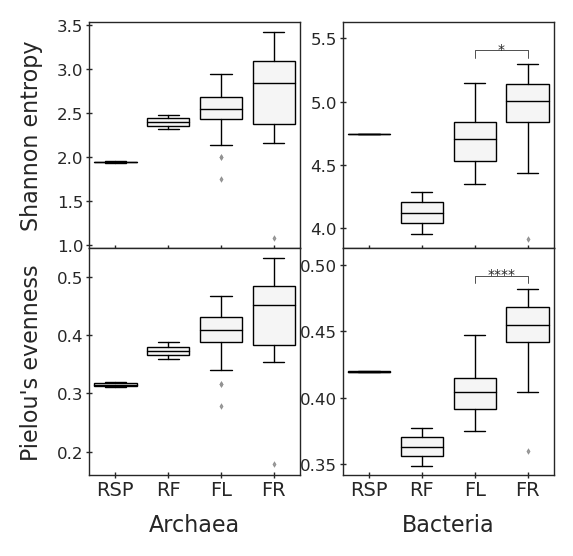

In [30]:
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)
metadata = meta.sort_values(['Day_num','BS'],ascending=[True,True])
#n = len(metadata.BS_Day.unique()) #number of groups to plot
#hours = {'24h':'lightseagreen','48h':'black'}
summary = pd.read_csv('Results/Alpha_test/Alpha_KW_BS.tsv',sep='\t',index_col=0)
fig, axes = plt.subplots(2,2,figsize=(3,3),sharex='col', gridspec_kw={'hspace':0,'wspace':.2})
axs,i = [[row,0] for row in range(2)]+[[row,1] for row in range(2)],0
order = ['RSP','RF','FL','FR']

for dom in domains:
 #if dom == 'Bacteria': continue
    for alpha in alphas:
        if alpha not in ['shannon','evenness']: continue
        alpha += '_'+dom
        md = metadata[metadata[alpha].notna()].copy()
        y = alpha     
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
 #ax.axis('off')
        ymax,ymin = md[y].max(),md[y].min() #get y limits
        data = md[md[alpha].notna()].copy() #get rid of empty for alpha rows
        sns.boxplot(x='BS',y=y,data=data,ax=ax,linewidth=0.5,fliersize=0.3,color='whitesmoke',order=order)

 #aesthetics
        ax.tick_params(axis='both',labelsize=6,length=2,pad=1,width=0.5,direction='inout')
        ax.tick_params(axis='x',labelsize=7)
        ax.set_xlabel(dom,fontsize=8,labelpad=5)
        ax.set_ylabel(alphas[alpha.split('_')[0]],fontsize=8,labelpad=5)
        if dom!='Archaea': ax.set_ylabel('')
        plt.setp(ax.artists, edgecolor = 'k')
        plt.setp(ax.lines, color='k')

 #stats
        summ = summary.loc[(summary.Metric==alpha)&(summary.Domain==dom)&(summary['q']!='-')].copy()
        if len(summ) > 0:
 #display(summ)
            summ = summ.loc[(summ['q'].astype(float)<=.05)]
            if len(summ) != 0:
                qs = {(summ.loc[ind,'Group1'],summ.loc[ind,'Group2']):float(summ.loc[ind,'q']) for ind in summ.index}
 #display(qs)
                add_stat_annotation(ax=ax,x='BS',y=y,box_pairs=list(qs.keys()),pvalues=list(qs.values()),line_height=.04,\
                                                        data=data,fontsize=5,loc='inside',perform_stat_test=False,order=order,\
                                                        text_offset=-2,line_offset=.01,line_offset_to_box=0.03,text_format='star',linewidth=.3)
#    ax.text(.5,-.3,dom,ha='center',fontsize=10,transform=ax.transAxes)
fig.align_labels()
plt.savefig('Figures/Alpha_diversity/Faith_Shannon_Bs.png',bbox_inches='tight',facecolor='w')

## BS, Treatment

In [31]:
#Kruskal-Wallis test
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)
summary,i = pd.DataFrame(),0
for dom in ['Bacteria','Archaea']:
    md = meta.copy()
    for bs in md.BS.unique():
        if bs in ['RSP','RF']: continue
        for alpha in alphas:
            alpha += '_'+dom
            meta = md.loc[md.BS==bs].copy()
            meta = meta[meta[alpha].notna()]
            kw,phoc = kw_test(meta,'Treatment',alpha,False,True)
            if kw[1] <= 0.05:
                for ind in phoc.index:
                    summary.loc[i,'Domain'] = dom
                    summary.loc[i,'Group'] = bs
                    summary.loc[i,'Metric'] = alpha
                    summary.loc[i,'p(kw)'] = kw[1]
                    summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                    summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                    summary.loc[i,'p'] = phoc.loc[ind,'p']
                    summary.loc[i,'q'] = phoc.loc[ind,'q']
                    i += 1
            else:
                summary.loc[i,'Domain'] = dom
                summary.loc[i,'Group'] = bs
                summary.loc[i,'Metric'] = alpha
                summary.loc[i,'p(kw)'] = kw[1]
                summary.loc[i,'Group1'] = '-'
                summary.loc[i,'Group2'] = '-'
                summary.loc[i,'p'] = '-'
                summary.loc[i,'q'] = '-'
                i += 1
!mkdir -p Results/Alpha_test
summary.to_csv('Results/Alpha_test/Alpha_KW_BS_Treatment.tsv',sep='\t')
display(summary)

,Domain,Group,Metric,p(kw),Group1,Group2,p,q
0,Bacteria,FR,shannon_Bacteria,0.653842,-,-,-,-
1,Bacteria,FR,evenness_Bacteria,0.634005,-,-,-,-
2,Bacteria,FR,observed_features_Bacteria,0.026149,TMR,AN1,0.248213,0.37232
3,Bacteria,FR,observed_features_Bacteria,0.026149,TMR,AN2,0.0209213,0.078455
4,Bacteria,FR,observed_features_Bacteria,0.026149,TMR,AT,0.148915,0.279215
5,Bacteria,FR,observed_features_Bacteria,0.026149,TMR,FV1,0.0832645,0.178424
6,Bacteria,FR,observed_features_Bacteria,0.026149,TMR,FV2,0.0832645,0.178424
7,Bacteria,FR,observed_features_Bacteria,0.026149,AN1,AN2,0.563703,0.650426
8,Bacteria,FR,observed_features_Bacteria,0.026149,AN1,AT,0.0832645,0.178424
9,Bacteria,FR,observed_features_Bacteria,0.026149,AN1,FV1,0.386476,0.483095


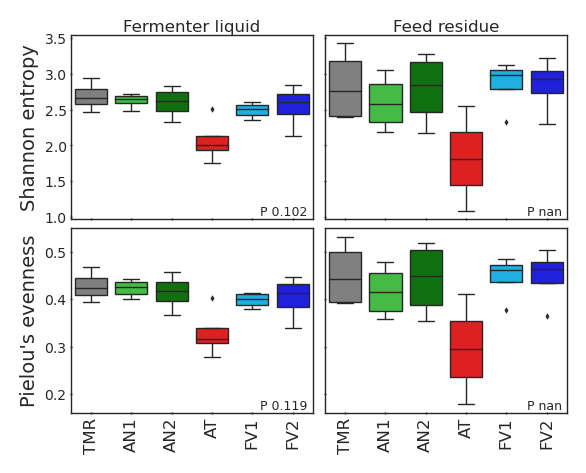

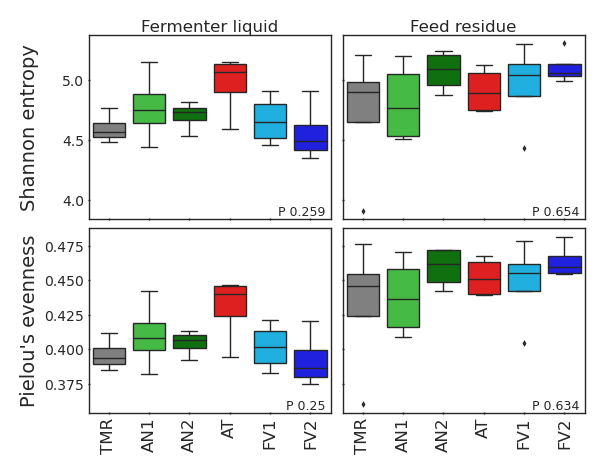

In [52]:
stypes = {'RF':'RF','RSP':'RSP','E':'Effluent','FL':'Fermenter liquid','FR':'Feed residue'}
groups = ['FL','FR']
summary = pd.read_csv('Results/Alpha_test/Alpha_KW_BS_Treatment.tsv',sep='\t',index_col=0)
names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)

for dom in ['Archaea','Bacteria']:
    md = meta.copy()
    md = md.fillna('N/A')
 #md.loc[md.Treatment=='not_appl','Trt'] = 'N/A'
    fig, axes = plt.subplots(2,len(groups),figsize=(3.2,2.5),sharey='row',sharex='col',\
                            gridspec_kw={'hspace':0.05,'wspace':0.05,})#'width_ratios':ratios
    axs,i = [[row,col] for row in range(len(alphas)) for col in range(len(groups))],0
    for alpha in alphas:
        if alpha not in ['evenness','shannon']: continue
        alpha += '_'+dom
        for g in groups:
            data = md.loc[(md.BS==g)].copy()
            data = data.loc[data[alpha] != 'N/A']
            order = [c for c in cdict.keys() if c in data.Treatment.tolist()]
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            sns.boxplot(x='Treatment',y=alpha,data=data,ax=ax,linewidth=0.5,fliersize=0.3,palette=cdict,order=order,)
            ax.tick_params(axis='both',labelsize=5,length=1,pad=1,width=0.5,direction='inout')
            ax.tick_params(axis='x',labelsize=6,labelrotation = 90)
            ax.set_ylabel('')
            ax.set_xlabel('')
            if g == groups[0]: 
                ax.set_ylabel(alphas[alpha.split('_')[0]],fontsize=7,labelpad=2)
 #if alpha == 'faith_pd':
 #    ax.text(-.5,0,dom,va='center',fontsize=8,rotation='vertical',transform=ax.transAxes)
            if 'shannon' in alpha: 
                ax.text(.5,1.02,stypes[g],ha='center',fontsize=6,transform=ax.transAxes)
            ax.set_ylim(auto=True)
            
 # Statistics
            summ = summary.loc[(summary.Metric==alpha)&(summary.Domain==dom)&(summary.Group==g)]
            ax.text(.98,.02,'P '+str(round(summ['p(kw)'].min(),3)),size=4.5,transform=ax.transAxes,ha='right') 
            summ = summ.loc[(summ['q']!='-')]
            summ = summ.loc[(summ['q'].astype(float)<=.05)]
            if len(summ) != 0:
                display(summ)
                if len(summ) != 0:
                    qs = {(summ.loc[ind,'Group1'],summ.loc[ind,'Group2']):float(summ.loc[ind,'q']) for ind in summ.index}
                    add_stat_annotation(ax=ax,x='Treatment',y=alpha,box_pairs=list(qs.keys()),pvalues=list(qs.values()),line_height=.04,\
                                                            data=data,fontsize=7,loc='inside',perform_stat_test=False,\
                                                            text_offset=-1,line_offset=.01,line_offset_to_box=0.03,text_format='star',linewidth=.5)
    fig.align_labels()
    plt.savefig('Figures/Alpha_diversity/%s-Faith_Shannon_Bs_Treatment.png'%dom,bbox_inches='tight',facecolor='w')

# LEfSe

## Preparing data

In [9]:
# Export relative tables as txt files
for dom in 'Archaea','Bacteria':
    outdir = 'Results/LEfSe/%s/' % dom 
    
 #to relative
    !qiime feature-table relative-frequency \
        --i-table Data/Tables/$dom-species-table.qza \
        --o-relative-frequency-table Data/Tables/$dom-species_rel_table.qza
    
 #outdir
    !mkdir -p $outdir
    
 #filter relative table by metadata
    !qiime feature-table filter-samples \
        --i-table Data/Tables/$dom-species_rel_table.qza \
        --m-metadata-file metadata.tsv \
        --p-where "[BS] IN ('FL','FR')" \
        --o-filtered-table $outdir/relative_table.qza
    
 #filer by relative abundances
    !qiime feature-table filter-features-conditionally \
        --i-table $outdir/relative_table.qza \
        --p-abundance .01 \
        --p-prevalence .1 \
        --o-filtered-table $outdir/relative_table.qza
    
 #export rel table
    !qiime tools export \
        --input-path $outdir/relative_table.qza \
        --output-path $outdir
    
 #convert to txt
    !biom convert -i $outdir/feature-table.biom -o $outdir/species_table.txt --to-tsv
    
 #remove biom
    !rm $outdir/feature-table.biom $outdir/relative_table.qza

Saved FeatureTable[RelativeFrequency] to: Data/Tables/Archaea-species_rel_table.qza
Saved FeatureTable[RelativeFrequency] to: Results/LEfSe/Archaea//relative_table.qza
Saved FeatureTable[RelativeFrequency] to: Results/LEfSe/Archaea//relative_table.qza
Exported Results/LEfSe/Archaea//relative_table.qza as BIOMV210DirFmt to directory Results/LEfSe/Archaea/
Saved FeatureTable[RelativeFrequency] to: Data/Tables/Bacteria-species_rel_table.qza
Saved FeatureTable[RelativeFrequency] to: Results/LEfSe/Bacteria//relative_table.qza
Saved FeatureTable[RelativeFrequency] to: Results/LEfSe/Bacteria//relative_table.qza
Exported Results/LEfSe/Bacteria//relative_table.qza as BIOMV210DirFmt to directory Results/LEfSe/Bacteria/


In [10]:
#Format tables for LEfSe to test each treatment vs control (TMR).
import pandas as pd

names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)
meta = meta.loc[~meta.BS.isin(['RSP','RF'])]
trts = sorted([t for t in meta.Treatment.unique() if t != 'TMR'])

for dom in 'Archaea','Bacteria':
    biom = pd.read_csv('Results/LEfSe/%s/species_table.txt'%dom,sep='\t',skiprows=1,index_col=0) #biom data
    md = meta.loc[[c for c in meta.index if c in biom.columns]].copy() #skip filtered from table samples
    md = md.sort_values(['Treatment','BS'],ascending=[True,True]) #sort metadata by Treatment and BS
    biom = biom[md.index] #sort biomdata by Treatment and BS
    biom.index = biom.index.str.split('_').str[-1] #last taxonomy unit
    biom.index = biom.index.str.replace(' ','_',regex=True) #replace spaces
    biom.loc['Class'] = md.T.loc['Treatment'] #add treatment as class
    biom.loc['Subclass'] = md.T.loc['BS'] #add bs as subclass
    
 # TMR vs Treatment:
    for trt in trts:
        df = biom[[c for c in biom.columns if biom.loc['Class',c] in ['TMR',trt]]].copy() #TMR vs trt
        df = df.reindex(df.index.tolist()[-2:]+df.index.tolist()[:-2])
        outdir = 'Results/LEfSe/%s/TMR-%s/' % (dom,trt)
        !mkdir -p $outdir
        df.to_csv(outdir+'/raw.txt',sep='\t',header=None)

## LEfSe. Run in LEfSe env!

In [ ]:
!pip install pandas

In [6]:
import pandas as pd

names = {'Trt1':'TMR','Trt2':'AN1','Trt3':'AN2','Trt4':'AT','Trt5':'FV1','Trt6':'FV2','not_appl':'N/A'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)
meta = meta.replace(names,regex=True)
meta = meta.loc[~meta.BS.isin(['RSP','RF'])]
trts = sorted([t for t in meta.Treatment.unique() if t != 'TMR'])

for dom in 'Archaea','Bacteria':
 # TMR vs Treatment:
        for trt in trts:
                print dom,'TMR vs ',trt,'*************************************************'
                outdir = 'Results/LEfSe/%s/TMR-%s/' % (dom,trt)
                raw = outdir+'raw.txt' #relative input data
                inp = outdir+'inp.txt' #format input data for LEfSe
                res = outdir+'res.tsv' #results
                !format_input.py $raw $inp -c 1 -s 2 -o 1000000
                !run_lefse.py $inp $res
                fig = outdir+'/plot.png'
                !plot_res.py $res $fig

Archaea TMR vs  AN1 *************************************************
Number of significantly discriminative features: 0 ( 0 ) before internal wilcoxon
No features with significant differences between the two classes
Number of discriminative features with abs LDA score > 2.0 : 0
No differentially abundant features found in Results/LEfSe/Archaea/TMR-AN1/res.tsv
Archaea TMR vs  AN2 *************************************************
Number of significantly discriminative features: 0 ( 0 ) before internal wilcoxon
No features with significant differences between the two classes
Number of discriminative features with abs LDA score > 2.0 : 0
No differentially abundant features found in Results/LEfSe/Archaea/TMR-AN2/res.tsv
Archaea TMR vs  AT *************************************************
Number of significantly discriminative features: 7 ( 7 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 7
Archaea TMR vs  FV1 ****************************************

## Summarize. Run in a working environment

In [6]:
# Summarize Aldex 2 runs
import os
import pandas as pd

summ = pd.DataFrame() #df to store all results
for dom in ['Bacteria','Archaea']:
    outdir = 'Results/LEfSe/%s/' % dom
    for out in os.listdir(outdir):
        if 'species_' in out: continue
        res = pd.read_csv(outdir+out+'/res.tsv',sep='\t',index_col=0,names=['Value','Prevailed_in','LDA','P'])
        res = res.loc[res.P!='-'] #remove rows with no results
        if len(res)==0: continue #skip if no results
        res['Domain'] = dom
        res['Treatment'] = out.split('-')[-1]
        for ind in res.index: #reverse sign if feature more abundant in the control
            if res.loc[ind,'Prevailed_in'] == 'TMR':
                res.loc[ind,'LDA'] = res.loc[ind,'LDA']*-1
        res = res[['LDA','P','Treatment','Domain']]
        summ = pd.concat([summ,res],ignore_index=False)
display(summ)
summ.to_csv('Results/LEfSe/summ.tsv',sep='\t')

,LDA,P,Treatment,Domain
Selenomonas_ruminantium,3.598584,0.0208625823328,FV1,Bacteria
Unclassified_Anaerovibrio,4.088349,0.0117186855998,AT,Bacteria
Unclassified_Streptococcus,3.905524,0.045999366875,AT,Bacteria
Unclassified_Alphaproteobacteria,-3.893071,0.00077753044694,AT,Bacteria
Prevotella_sp_,4.242101,0.0274231543814,AT,Bacteria
Unclassified_Methanomicrobium,-4.938660,0.00232209451588,FV2,Archaea
Methanomicrobium_mobile,-4.418672,0.00232209451588,FV2,Archaea
Methanobrevibacter_sp_,5.162145,0.00162918629697,AT,Archaea
Unclassified_Thermoplasmata,-4.919127,0.0356919001168,AT,Archaea
Methanobrevibacter_millerae,-4.096841,0.00113132642682,AT,Archaea


## LEfSe significance plot

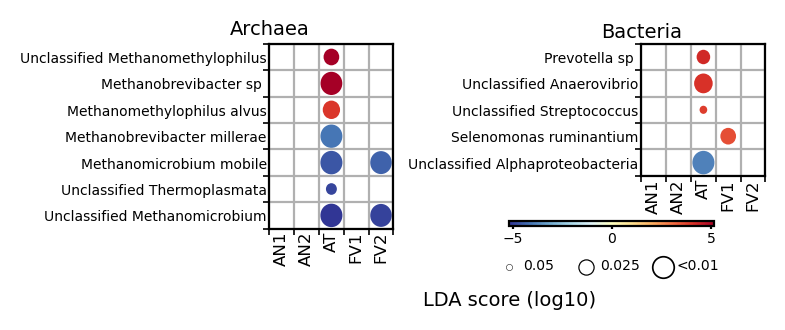

In [8]:
#Significance plot (effect as color and inversed p as size)
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

domains = ['Archaea','Bacteria']
summ = pd.read_csv('Results/LEfSe/summ.tsv',sep='\t',index_col=0) #LEfSe summary
summ['id'] = summ.index
# set hights for figure by domains
lengths = [len(summ.loc[(summ.Domain==dom)].copy().index.unique()) for dom in domains]

#set figure
fig,axes = plt.subplots(1,2,figsize=(3.2,1.2),gridspec_kw={'wspace':2})
vmax,vmin = summ.LDA.max(),summ.LDA.min() #max and min values for cbar
divnorm = colors.TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax) #set cbar with 0 as center

#colorbar 
cbar_ax = fig.add_axes([.5, .12, .32, .02])
cbar_ax.tick_params(labelsize=5,length=1,pad=1)

!mkdir -p Figures/LEfSe
for i,dom in enumerate(domains):     
 #set ax
    ax = axes[i]
    ax.axis('off')

 #loc aldex summary by domain
    lefse = summ.loc[summ.Domain==dom].copy()
    if len(lefse) == 0: continue #skip if no sign results from lefse for domain

 #coordinate matrix and input tables
    xlabs = ['AN1','AN2','AT','FV1','FV2'] #xlabels and columns
    rows = len(lefse.index.unique()) #number of features
    cols = len(xlabs) #number of treatments vs TMR
    xax,yax = np.meshgrid(np.arange(cols), np.arange(rows)) #coordinate matrix
    effects = lefse.pivot(index='id', columns='Treatment', values='LDA').copy() #effects as colors
    pvalues = lefse.pivot(index='id', columns='Treatment', values='P').copy() #p-values as sizes

 #add missing treatments and order columns
    for x in xlabs:
        if x not in effects.columns:
            effects[x] = np.nan
            pvalues[x] = np.nan
    effects = effects[xlabs] #sort columns
    pvalues = pvalues[xlabs] #sort columns

 #sort tables by max effect
    effects = effects.assign(m=effects.max(axis=1)).sort_values('m',ascending=True).drop('m', axis=1)
    ylabs = effects.index.tolist()
    pvalues = pvalues.reindex(ylabs)

 #Significance plots
    R = (((pvalues/.07 -1)/2)*-.9) #radius of circle based on significance (lower p - bigger radius)
    ylow = rows/max(lengths) #lower y point for inner ax to regulate height of the subplot
    ax = ax.inset_axes([0,1-ylow,1,ylow]) #set inner ax
    circles = [plt.Circle((j,i),radius=r) for r,j,i in zip(R.to_numpy().flat,xax.flat,yax.flat)] #ser circles
    plot = PatchCollection(circles,array=effects.to_numpy().flatten(),cmap="RdYlBu_r",norm=divnorm) #plot circles
    plot.set_clim(vmin,vmax) #cbar range
    ax.add_collection(plot) #add plot
    ax.grid(which='minor') #add grid
    ax.text(0,1.05,dom,ha='center',fontsize=7,transform=ax.transAxes) #add domain
    ax.set(xticks=np.arange(cols),yticks=np.arange(rows),xticklabels=xlabs,yticklabels=ylabs) #add data
    ax.set_xticks(np.arange(cols+1)-0.5, minor=True)
    ax.set_yticks(np.arange(rows+1)-0.5, minor=True)
 #ylabs = [l.replace('unid_methanogen','').replace('_YAB2003_','(YAB2003)').replace('uncl_p_251_o5__uncl','Bacteroidales(p-251-o5)')\
 #                 .replace('Candidatus_M','M').replace('uncl_RC9_gut__uncl','(RC9)').replace('_u_b','').replace('uncl(F082)','Bacteroidales_(F082)')\
 #                .replace('u_M','M').replace('Prevotella_7','Prevotella_(7)').replace('_uncl','_').replace('_sp','') for l in ylabs]
    ax.set_yticklabels([y.replace('Candidatus_','').replace('_',' ') for y in ylabs])
    ax.tick_params(axis='both',which='major',labelsize=5,length=0,pad=1,rotation=0)
    ax.tick_params(axis='x',rotation=90,labelsize=6)        
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.colorbar(plot,ax=ax,cax=cbar_ax,orientation='horizontal')

#size bar
sizes = {5:'0.05',30:'0.025',60:'<0.01'}
sbar_ax = fig.add_axes([.5, -0.1, .3, .05])
sbar_ax.tick_params(labelsize=5,length=1)
sbar_ax.axis('off')
sbar_ax.set_ylim(0,1)
sbar_ax.set_xlim(0,1)
step = .4
yax, xax = 1, 0
for s in sizes: #sizes
    sns.scatterplot(x=[xax],y=[yax],marker='o',color='white',ax=sbar_ax,s=s,legend=False,edgecolor='black',clip_on=False)
    sbar_ax.text(xax+.07,yax-.18,sizes[s],fontdict={'size':5})
    xax += step

#fig.align_labels()
fig.suptitle('LDA score (log10)',fontsize=7,y=-.15)
plt.savefig('Figures/LEfSe/LEfSe_significance_plot.png',bbox_inches='tight',facecolor='w')

# ANCOM-BC

In [7]:
#run AncomBC
domains = ['Bacteria', 'Archaea', 'Eukaryota']
for dom in domains:
    TABLE = f'{TABS}/{dom}-species-table.qza'
    outdir = f'Results/Ancom-BC/{dom}'
    retain = f"[BS] IN ('FL', 'FR')"
    tabex = f'{outdir}/table.qza'
    ancom = f'{outdir}/differentials.qza'
    ancov = f'{outdir}/da-barplot.qzv'

    !mkdir -p $outdir

    #filter by sample type
    !qiime feature-table filter-samples \
        --i-table $TABLE \
        --m-metadata-file metadata.tsv \
        --p-where "$retain" \
        --o-filtered-table $tabex
    
    #filer by relative abundances
    !qiime feature-table filter-features-conditionally \
        --i-table $tabex \
        --p-abundance .01 \
        --p-prevalence .1 \
        --o-filtered-table $tabex

    #run ancom-bc
    !qiime composition ancombc \
        --i-table $tabex \
        --m-metadata-file metadata.tsv \
        --p-formula 'Trt + BS + rstc_run' \
        --p-reference-levels Trt::TMR \
        --o-differentials $ancom

    #da-barplot
    !qiime composition da-barplot \
        --i-data $ancom \
        --o-visualization $ancov

Saved FeatureTable[Frequency] to: Results/Ancom-BC/Bacteria/table.qza
Saved FeatureTable[Frequency] to: Results/Ancom-BC/Bacteria/table.qza
Saved FeatureData[DifferentialAbundance] to: Results/Ancom-BC/Bacteria/differentials.qza
Saved Visualization to: Results/Ancom-BC/Bacteria/da-barplot.qzv
Saved FeatureTable[Frequency] to: Results/Ancom-BC/Archaea/table.qza
Saved FeatureTable[Frequency] to: Results/Ancom-BC/Archaea/table.qza
Saved FeatureData[DifferentialAbundance] to: Results/Ancom-BC/Archaea/differentials.qza
Saved Visualization to: Results/Ancom-BC/Archaea/da-barplot.qzv
Saved FeatureTable[Frequency] to: Results/Ancom-BC/Eukaryota/table.qza
Saved FeatureTable[Frequency] to: Results/Ancom-BC/Eukaryota/table.qza
Saved FeatureData[DifferentialAbundance] to: Results/Ancom-BC/Eukaryota/differentials.qza
Saved Visualization to: Results/Ancom-BC/Eukaryota/da-barplot.qzv


In [8]:
#merge Ancom-BC outputs

#get effect sizes and q-values
def anconbc_unzip(qza):    
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    lfc = pd.read_csv(f'{out}/data/lfc_slice.csv', sep=',')
    qval = pd.read_csv(f'{out}/data/q_val_slice.csv', sep=',')
    !rm -rf $out
    return lfc, qval


summ = pd.DataFrame()
domains = ['Bacteria', 'Archaea', 'Eukaryota']
for dom in domains:
    outdir = f'Results/Ancom-BC/{dom}'
    ancom = f'{outdir}/differentials.qza'
    lfc, qval = anconbc_unzip(ancom)
    lfc = lfc.melt(id_vars='id', value_name='LFC', var_name='Trt')
    qval = qval.melt(id_vars='id', value_name='qval', var_name='Trt')
    lfc['qval'] = qval['qval']
    lfc = lfc.loc[lfc.Trt.str.contains('Trt')]
    lfc.Trt = lfc.Trt.str.replace('Trt', '')
    lfc['Domain'] = dom
    summ = pd.concat([summ, lfc])
summ = summ.loc[summ['qval'] <= .05]
display(summ)
summ.to_csv(f'Results/Ancom-BC/summ.tsv', sep='\t') 

,id,Trt,LFC,qval,Domain
60,k_Bacteria;p_Firmicutes;c_Clostridia;o_Eubacte...,AN1,0.369435,8.641613e-03,Bacteria
112,k_Bacteria;p_Firmicutes;c_Negativicutes;o_Sele...,AT,0.922624,4.000411e-04,Bacteria
119,k_Bacteria;p_Bacteroidetes;c_Bacteroidia;o_Bac...,AT,1.062278,7.068670e-04,Bacteria
126,k_Bacteria;p_Proteobacteria;c_Alphaproteobacte...,AT,-4.135888,6.127484e-49,Bacteria
136,k_Bacteria;p_Firmicutes;c_Clostridia;o_Clostri...,AT,-0.913772,5.136157e-04,Bacteria
139,k_Bacteria;p_Firmicutes;c_Clostridia;o_Unclass...,AT,-0.612665,4.598481e-02,Bacteria
140,k_Bacteria;p_Bacteroidetes;c_Bacteroidia;o_Bac...,AT,1.532329,1.562387e-02,Bacteria
144,k_Bacteria;p_Firmicutes;c_Negativicutes;o_Sele...,FV1,0.858220,2.579110e-02,Bacteria
168,k_Bacteria;p_Firmicutes;c_Clostridia;o_Eubacte...,FV1,0.348241,2.724964e-03,Bacteria
199,k_Bacteria;p_Firmicutes;c_Bacilli;o_Lactobacil...,FV2,-0.708823,2.206367e-02,Bacteria


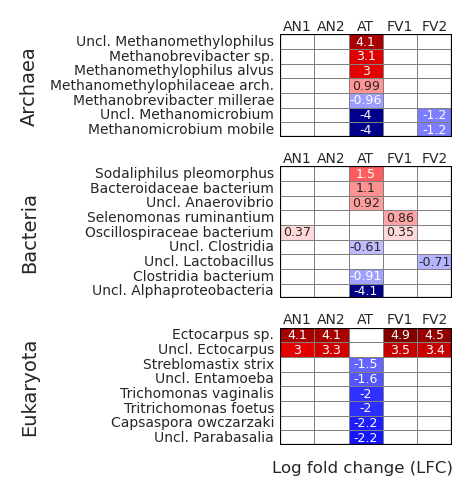

In [4]:
# plot
!mkdir -p Figures/AncomBC

#dictionary to modify taxa IDs
drep = {
    'Candidatus ': '',
    'Unclassified': 'Uncl.',
    'archaeon': 'arch.',
    '_': ' ',}

domains = ['Archaea', 'Bacteria', 'Eukaryota']

#read summary
summ = pd.read_csv(f'Results/Ancom-BC/summ.tsv', sep='\t', index_col=0) 
summ = summ.loc[~summ.id.str.contains('Fucales')]
vmax = summ.LFC.max()
vmin = summ.LFC.min()

#replace some substrings in IDs
summ.id = summ.id.str.split(';s_').str[-1]
for k, v in drep.items():
    summ.id = summ.id.apply(lambda x: x.replace(k, v))

#learn heights of subplots and order of ids
grouped = pd.DataFrame(summ.groupby('id')['LFC'].sum())
grouped.sort_values(by='LFC', ascending=False, inplace=True)
order = grouped.index.tolist()
id_order = [summ.loc[summ.Domain == dom].id.unique().tolist() for dom in domains]
id_order = [[i for i in order if i in l] for l in id_order]
heights = [len(l) for l in id_order]

S = 9 #scale figure size
H = sum(heights)/S #height of figure
W = 10/S #width of figure
step = 1/sum(heights) #height of 1 line
sorter = list(CDICT.keys())[1:-1] #columns to plot
stypes = ['E', 'FL', 'FR']

#set figure
fig, axes = plt.subplots(len(domains), 1, figsize=(W, H), 
                         gridspec_kw={'hspace': 6*step, 'height_ratios': heights})

for i, dom in enumerate(domains):

    #data
    df = summ.loc[(summ.Domain == dom)].copy()
    hdf = df.pivot(index='id', columns='Trt', values='LFC')

    #sort columns
    for col in sorter:
        if col not in hdf.columns:
            hdf[col] = np.nan
    hdf = hdf[sorter]

    #sort rows
    for ind in id_order[i]:
        if ind not in hdf.index:
            hdf.loc[ind, :] = np.nan
    hdf = hdf.reindex(id_order[i])
        

    #plot
    ax = axes[i]
    sns.heatmap(data=hdf, ax=ax, annot=True, cbar=False, square=False, center=0, cmap='seismic', 
                xticklabels=False, yticklabels=True, annot_kws={"size":4.5}, linewidths=.3, 
                linecolor='grey', vmax=vmax, vmin=vmin)

    #aesthetics
    ax.set_xlabel('')
    ax.set_ylabel(dom, fontsize=7)

    left, right = True, False
    ax.tick_params(labelleft=left, labelright=right, axis='both', which='both', labelsize=5, 
                   length=0, pad=2, rotation=0)

    #annotate 
    for pos, lab in enumerate(sorter):
        ax.text(pos+.5, -1, lab, size=5, ha='center', va='top', transform=ax.transData)

    #lines around axes
    ax.axhline(y=0, color='k',linewidth=.8)
    ax.axhline(y=len(hdf), color='k',linewidth=.8)
    ax.axvline(x=0, color='k',linewidth=.8)
    ax.axvline(x=len(sorter), color='k',linewidth=.8)

fig.align_labels()
fig.suptitle('Log fold change (LFC)', fontsize=6, y=.08, x=.5)
plt.savefig('Figures/AncomBC/Ancom-BC.png', bbox_inches='tight', facecolor='w')

## LEfSe significance plot

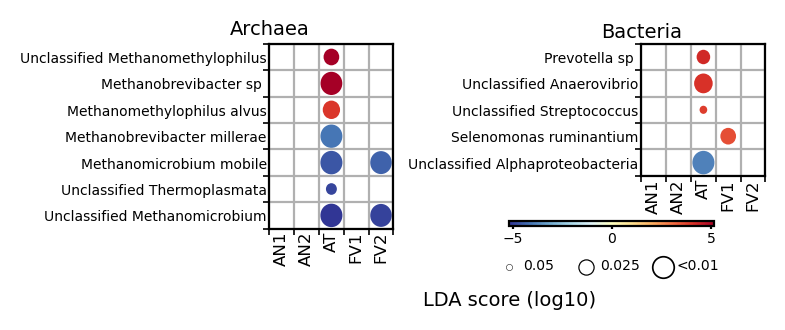

In [8]:
#Significance plot (effect as color and inversed p as size)
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

domains = ['Archaea','Bacteria']
summ = pd.read_csv('Results/LEfSe/summ.tsv',sep='\t',index_col=0) #LEfSe summary
summ['id'] = summ.index
# set hights for figure by domains
lengths = [len(summ.loc[(summ.Domain==dom)].copy().index.unique()) for dom in domains]

#set figure
fig,axes = plt.subplots(1,2,figsize=(3.2,1.2),gridspec_kw={'wspace':2})
vmax,vmin = summ.LDA.max(),summ.LDA.min() #max and min values for cbar
divnorm = colors.TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax) #set cbar with 0 as center

#colorbar 
cbar_ax = fig.add_axes([.5, .12, .32, .02])
cbar_ax.tick_params(labelsize=5,length=1,pad=1)

!mkdir -p Figures/LEfSe
for i,dom in enumerate(domains):     
 #set ax
    ax = axes[i]
    ax.axis('off')

 #loc aldex summary by domain
    lefse = summ.loc[summ.Domain==dom].copy()
    if len(lefse) == 0: continue #skip if no sign results from lefse for domain

 #coordinate matrix and input tables
    xlabs = ['AN1','AN2','AT','FV1','FV2'] #xlabels and columns
    rows = len(lefse.index.unique()) #number of features
    cols = len(xlabs) #number of treatments vs TMR
    xax,yax = np.meshgrid(np.arange(cols), np.arange(rows)) #coordinate matrix
    effects = lefse.pivot(index='id', columns='Treatment', values='LDA').copy() #effects as colors
    pvalues = lefse.pivot(index='id', columns='Treatment', values='P').copy() #p-values as sizes

 #add missing treatments and order columns
    for x in xlabs:
        if x not in effects.columns:
            effects[x] = np.nan
            pvalues[x] = np.nan
    effects = effects[xlabs] #sort columns
    pvalues = pvalues[xlabs] #sort columns

 #sort tables by max effect
    effects = effects.assign(m=effects.max(axis=1)).sort_values('m',ascending=True).drop('m', axis=1)
    ylabs = effects.index.tolist()
    pvalues = pvalues.reindex(ylabs)

 #Significance plots
    R = (((pvalues/.07 -1)/2)*-.9) #radius of circle based on significance (lower p - bigger radius)
    ylow = rows/max(lengths) #lower y point for inner ax to regulate height of the subplot
    ax = ax.inset_axes([0,1-ylow,1,ylow]) #set inner ax
    circles = [plt.Circle((j,i),radius=r) for r,j,i in zip(R.to_numpy().flat,xax.flat,yax.flat)] #ser circles
    plot = PatchCollection(circles,array=effects.to_numpy().flatten(),cmap="RdYlBu_r",norm=divnorm) #plot circles
    plot.set_clim(vmin,vmax) #cbar range
    ax.add_collection(plot) #add plot
    ax.grid(which='minor') #add grid
    ax.text(0,1.05,dom,ha='center',fontsize=7,transform=ax.transAxes) #add domain
    ax.set(xticks=np.arange(cols),yticks=np.arange(rows),xticklabels=xlabs,yticklabels=ylabs) #add data
    ax.set_xticks(np.arange(cols+1)-0.5, minor=True)
    ax.set_yticks(np.arange(rows+1)-0.5, minor=True)
 #ylabs = [l.replace('unid_methanogen','').replace('_YAB2003_','(YAB2003)').replace('uncl_p_251_o5__uncl','Bacteroidales(p-251-o5)')\
 #                 .replace('Candidatus_M','M').replace('uncl_RC9_gut__uncl','(RC9)').replace('_u_b','').replace('uncl(F082)','Bacteroidales_(F082)')\
 #                .replace('u_M','M').replace('Prevotella_7','Prevotella_(7)').replace('_uncl','_').replace('_sp','') for l in ylabs]
    ax.set_yticklabels([y.replace('Candidatus_','').replace('_',' ') for y in ylabs])
    ax.tick_params(axis='both',which='major',labelsize=5,length=0,pad=1,rotation=0)
    ax.tick_params(axis='x',rotation=90,labelsize=6)        
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.colorbar(plot,ax=ax,cax=cbar_ax,orientation='horizontal')

#size bar
sizes = {5:'0.05',30:'0.025',60:'<0.01'}
sbar_ax = fig.add_axes([.5, -0.1, .3, .05])
sbar_ax.tick_params(labelsize=5,length=1)
sbar_ax.axis('off')
sbar_ax.set_ylim(0,1)
sbar_ax.set_xlim(0,1)
step = .4
yax, xax = 1, 0
for s in sizes: #sizes
    sns.scatterplot(x=[xax],y=[yax],marker='o',color='white',ax=sbar_ax,s=s,legend=False,edgecolor='black',clip_on=False)
    sbar_ax.text(xax+.07,yax-.18,sizes[s],fontdict={'size':5})
    xax += step

#fig.align_labels()
fig.suptitle('LDA score (log10)',fontsize=7,y=-.15)
plt.savefig('Figures/LEfSe/LEfSe_significance_plot.png',bbox_inches='tight',facecolor='w')

In [146]:
import pandas as pd
meta = pd.read_csv('/home/meco/Downloads/metadata.tsv', sep='\t', index_col=0)
path = pd.read_csv('/home/meco/Downloads/rstc_pathabundance.tsv', sep='\t', index_col=0)
path = path.T
path['Trt'] = meta['Treatment']
path = path[['Trt'] + [c for c in path.columns if c != 'Trt']]
path
path.T.to_csv('/home/meco/Downloads/path_ab.tsv', sep='\t')